In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import catboost as cb
print("cb.__version__:", cb.__version__)

# local modules
import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

cb.__version__: 1.2.7


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# Load the feature selection results
fs_type = 'full'

In [4]:
# Parameters
fs_type = "fsv23"


In [5]:
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 141
Categorical features: 9
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=False if fs_type=="full" else True,
    include_text_features=False,
)

text_cols = list()

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0
number of constant cols:  0


Numerical Columns: 213
Categorical Columns: 9


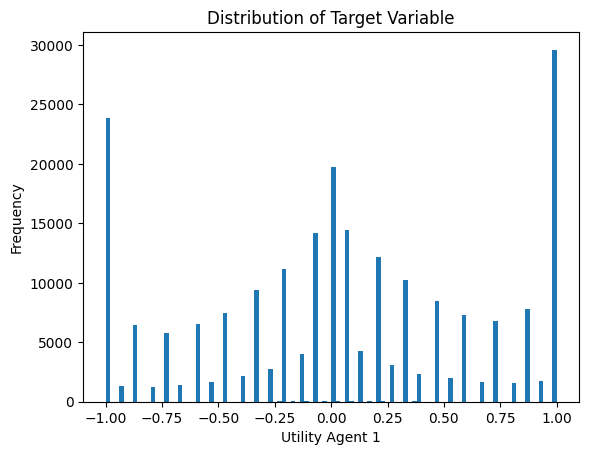

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model

In [9]:
def get_feature_importance(model, importance_type='PredictionValuesChange'):
    """
    Get feature importance from a trained CatBoost model
    
    Args:
        model: Trained CatBoost model
        importance_type: Type of feature importance to calculate
            Options: 'PredictionValuesChange', 'LossFunctionChange', 
            'ShapValues', 'Interaction', 'TopKitty'
        
    Returns:
        pandas.DataFrame: DataFrame containing feature names and their importance scores
    """
    # Get feature importance scores
    importance_scores = model.get_feature_importance(type=importance_type)
    feature_names = model.feature_names_
    
    # Create dataframe with feature names and importance scores
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance_scores
    }).sort_values('importance', ascending=False, ignore_index=True)
    
    return importance_df


def plot_feature_importance(importance_df, top_n=100):
    plot_df = importance_df.head(top_n)
    
    plt.figure(figsize=(15, 5))
    plt.bar(x=range(len(plot_df)), height=plot_df['importance'])
    plt.xticks(range(len(plot_df)), plot_df['feature'], rotation=45, ha='right', fontsize=8)
    plt.ylabel('Importance Score')
    plt.title(f'Top {top_n} Most Important Features')
    plt.tight_layout()
    plt.show()

In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        text_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters for CatBoost
    params = {

        'objective': "RMSE",
        'learning_rate': 0.1,
        'depth': 10,
        'iterations': 3000,
        'eval_metric': 'RMSE',
        'verbose': 0,
        'random_seed': 2112,
        'l2_leaf_reg': 1.,
        'random_strength': 0.2,
        'min_data_in_leaf': 50,
        'rsm': 0.8,
        'bagging_temperature' : 0.50,

        # 'text_processing': {
        #     'tokenizers': [{
        #         'tokenizer_id': 'Space',  # or 'GPT', 'Bert', etc.
        #         'separator_type': 'Space'
        #     }],
        #     'dictionaries': [{
        #         'dictionary_id': 'BiGram',
        #         'max_dictionary_size': '50000',
        #         'occurrence_lower_bound': '3',
        #         'gram_order': '2'
        #     }],
        #     'feature_calcers': [{
        #         'calcer_type': 'BoW',  # or 'NaiveBayes', 'BM25'
        #         'dictionary_id': 'BiGram'
        #     }]
        # }


        # # Text processing parameters to mimic TF-IDF
        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'separator_type': 'ByDelimiter',
        #     'delimiter': ' '
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'NgramDict',
        #     'max_dictionary_size': '500',  # Match max_features=500
        #     'occurrence_lower_bound': '3',
        #     'gram_order': '3',  # Maximum n-gram size
        #     'min_gram_order': '2'  # Minimum n-gram size
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',  # Most similar to TF-IDF
        #     'dictionary_id': 'NgramDict'
        # }],


        # 'tokenizers': [{
        #     'tokenizer_id': 'Space',
        #     'delimiter': ' ',
        #     'separator_type': 'ByDelimiter'
        # }],
        # 'dictionaries': [{
        #     'dictionary_id': 'Word',
        #     'max_dictionary_size': '50000',
        #     'occurrence_lower_bound': '3'
        # }],
        # 'feature_calcers': [{
        #     'calcer_type': 'BoW',
        #     'dictionary_id': 'Word',
        # }]
    }
    # Obtained with optuna
    # params = {
    #     'objective': 'RMSE',
    #     'verbose': False,
    #     'random_seed': 2112,
    #     'learning_rate': 0.1,
    #     'iterations': 3000,
    #     'bootstrap_type': 'Bayesian',
    #     'sampling_frequency': 'PerTreeLevel',
    #     'depth': 10,
    #     'l2_leaf_reg': 0.9359292512255313,
    #     'random_strength': 0.16693257025108216,
    #     'bagging_temperature': 0.15967219011745193,
    #     'rsm': 0.548125395769786,
    #     'min_data_in_leaf': 102,
    #     'max_ctr_complexity': 10
    # }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_valid = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_valid = X_train[target], X_valid[target]

        # Initialize CatBoost Pool
        train_pool = cb.Pool(
            # data=X_train[numerical_cols + categorical_cols + text_cols],
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        val_pool = cb.Pool(
            # data=X_valid[numerical_cols + categorical_cols + text_cols],
            data=X_valid[numerical_cols + categorical_cols],
            label=y_valid,
            cat_features=categorical_cols,
            # text_features=text_cols
        )
        
        # Initialize CatBoost Regressor
        model = cb.CatBoostRegressor(**params)
        
        # Train the model
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            verbose=50
        )

        feat_importance = get_feature_importance(model)
        feat_importance = feat_importance.rename(columns={'importance': f'importance_f{fold}'})
        feat_importance_dfs.append(feat_importance)
        plot_feature_importance(feat_importance.rename(columns={f'importance_f{fold}': 'importance'}))
        
        # Save the trained model to the list
        trained_models.append(model)

        # Predict on validation set
        y_pred = model.predict(val_pool)

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_valid
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_valid) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))

    return trained_models, oof, oof_scores, importance_df

Fold 1


0:	learn: 0.6141672	test: 0.5473315	best: 0.5473315 (0)	total: 137ms	remaining: 6m 51s


50:	learn: 0.3909422	test: 0.4702283	best: 0.4702283 (50)	total: 3.59s	remaining: 3m 27s


100:	learn: 0.3471982	test: 0.4506021	best: 0.4506021 (100)	total: 7.33s	remaining: 3m 30s


150:	learn: 0.3245366	test: 0.4424201	best: 0.4424201 (150)	total: 11s	remaining: 3m 28s


200:	learn: 0.3084011	test: 0.4391991	best: 0.4391991 (200)	total: 14.7s	remaining: 3m 25s


250:	learn: 0.2972415	test: 0.4364912	best: 0.4364912 (250)	total: 18.5s	remaining: 3m 22s


300:	learn: 0.2882011	test: 0.4345238	best: 0.4345238 (300)	total: 22.3s	remaining: 3m 19s


350:	learn: 0.2806176	test: 0.4333292	best: 0.4333292 (350)	total: 26.2s	remaining: 3m 17s


400:	learn: 0.2737730	test: 0.4322740	best: 0.4322409 (399)	total: 29.9s	remaining: 3m 14s


450:	learn: 0.2680888	test: 0.4317526	best: 0.4316940 (441)	total: 33.8s	remaining: 3m 10s


500:	learn: 0.2627454	test: 0.4309756	best: 0.4309367 (496)	total: 37.6s	remaining: 3m 7s


550:	learn: 0.2574430	test: 0.4306385	best: 0.4306349 (547)	total: 41.5s	remaining: 3m 4s


600:	learn: 0.2526131	test: 0.4300656	best: 0.4300656 (600)	total: 45.4s	remaining: 3m 1s


650:	learn: 0.2485425	test: 0.4298602	best: 0.4298215 (649)	total: 49.2s	remaining: 2m 57s


700:	learn: 0.2449390	test: 0.4295861	best: 0.4295861 (700)	total: 53s	remaining: 2m 53s


750:	learn: 0.2414010	test: 0.4291035	best: 0.4291035 (750)	total: 56.9s	remaining: 2m 50s


800:	learn: 0.2381478	test: 0.4291702	best: 0.4290829 (773)	total: 1m	remaining: 2m 46s


850:	learn: 0.2354750	test: 0.4290659	best: 0.4290221 (825)	total: 1m 4s	remaining: 2m 43s


900:	learn: 0.2328236	test: 0.4289098	best: 0.4289004 (885)	total: 1m 8s	remaining: 2m 39s


950:	learn: 0.2300828	test: 0.4287656	best: 0.4287447 (948)	total: 1m 12s	remaining: 2m 35s


1000:	learn: 0.2275547	test: 0.4286950	best: 0.4286198 (970)	total: 1m 16s	remaining: 2m 32s


1050:	learn: 0.2250839	test: 0.4286512	best: 0.4285953 (1040)	total: 1m 19s	remaining: 2m 28s


1100:	learn: 0.2226148	test: 0.4282939	best: 0.4282939 (1100)	total: 1m 23s	remaining: 2m 24s


1150:	learn: 0.2207151	test: 0.4283553	best: 0.4282717 (1104)	total: 1m 27s	remaining: 2m 20s


1200:	learn: 0.2183410	test: 0.4283006	best: 0.4282564 (1189)	total: 1m 31s	remaining: 2m 17s


1250:	learn: 0.2163326	test: 0.4281792	best: 0.4281624 (1247)	total: 1m 35s	remaining: 2m 13s


1300:	learn: 0.2140875	test: 0.4281757	best: 0.4281375 (1275)	total: 1m 39s	remaining: 2m 9s


1350:	learn: 0.2120024	test: 0.4281245	best: 0.4280509 (1324)	total: 1m 43s	remaining: 2m 6s


1400:	learn: 0.2098544	test: 0.4279490	best: 0.4279490 (1400)	total: 1m 47s	remaining: 2m 2s


1450:	learn: 0.2078539	test: 0.4278819	best: 0.4278687 (1431)	total: 1m 50s	remaining: 1m 58s


1500:	learn: 0.2062747	test: 0.4278620	best: 0.4278263 (1467)	total: 1m 54s	remaining: 1m 54s


1550:	learn: 0.2044580	test: 0.4277342	best: 0.4276839 (1531)	total: 1m 58s	remaining: 1m 50s


1600:	learn: 0.2025977	test: 0.4276064	best: 0.4275981 (1599)	total: 2m 2s	remaining: 1m 47s


1650:	learn: 0.2009466	test: 0.4276422	best: 0.4275896 (1647)	total: 2m 6s	remaining: 1m 43s


1700:	learn: 0.1992532	test: 0.4275203	best: 0.4275175 (1693)	total: 2m 10s	remaining: 1m 39s


1750:	learn: 0.1975964	test: 0.4274965	best: 0.4274756 (1726)	total: 2m 13s	remaining: 1m 35s


1800:	learn: 0.1961291	test: 0.4274207	best: 0.4274207 (1800)	total: 2m 17s	remaining: 1m 31s


1850:	learn: 0.1945463	test: 0.4273336	best: 0.4273251 (1846)	total: 2m 21s	remaining: 1m 28s


1900:	learn: 0.1929957	test: 0.4273254	best: 0.4273227 (1896)	total: 2m 25s	remaining: 1m 24s


1950:	learn: 0.1915057	test: 0.4273255	best: 0.4273227 (1896)	total: 2m 29s	remaining: 1m 20s


2000:	learn: 0.1900956	test: 0.4273309	best: 0.4273195 (1956)	total: 2m 33s	remaining: 1m 16s


2050:	learn: 0.1886157	test: 0.4273494	best: 0.4273195 (1956)	total: 2m 37s	remaining: 1m 12s


2100:	learn: 0.1872037	test: 0.4273895	best: 0.4273195 (1956)	total: 2m 41s	remaining: 1m 8s


2150:	learn: 0.1858489	test: 0.4273801	best: 0.4273195 (1956)	total: 2m 44s	remaining: 1m 5s


2200:	learn: 0.1845553	test: 0.4274247	best: 0.4273195 (1956)	total: 2m 48s	remaining: 1m 1s


2250:	learn: 0.1831922	test: 0.4274850	best: 0.4273195 (1956)	total: 2m 52s	remaining: 57.4s


2300:	learn: 0.1820160	test: 0.4274295	best: 0.4273195 (1956)	total: 2m 56s	remaining: 53.6s


2350:	learn: 0.1806372	test: 0.4274759	best: 0.4273195 (1956)	total: 3m	remaining: 49.9s


2400:	learn: 0.1794470	test: 0.4275856	best: 0.4273195 (1956)	total: 3m 4s	remaining: 46.2s


2450:	learn: 0.1783067	test: 0.4275346	best: 0.4273195 (1956)	total: 3m 9s	remaining: 42.3s


2500:	learn: 0.1772097	test: 0.4274977	best: 0.4273195 (1956)	total: 3m 13s	remaining: 38.5s


2550:	learn: 0.1759931	test: 0.4274693	best: 0.4273195 (1956)	total: 3m 16s	remaining: 34.7s


2600:	learn: 0.1747778	test: 0.4274985	best: 0.4273195 (1956)	total: 3m 20s	remaining: 30.8s


2650:	learn: 0.1737693	test: 0.4274772	best: 0.4273195 (1956)	total: 3m 24s	remaining: 26.9s


2700:	learn: 0.1725939	test: 0.4275304	best: 0.4273195 (1956)	total: 3m 28s	remaining: 23.1s


2750:	learn: 0.1715458	test: 0.4275423	best: 0.4273195 (1956)	total: 3m 32s	remaining: 19.2s


2800:	learn: 0.1704777	test: 0.4275722	best: 0.4273195 (1956)	total: 3m 36s	remaining: 15.4s


2850:	learn: 0.1693816	test: 0.4275495	best: 0.4273195 (1956)	total: 3m 40s	remaining: 11.5s


2900:	learn: 0.1682230	test: 0.4276095	best: 0.4273195 (1956)	total: 3m 43s	remaining: 7.64s


2950:	learn: 0.1672338	test: 0.4276172	best: 0.4273195 (1956)	total: 3m 47s	remaining: 3.78s


2999:	learn: 0.1661090	test: 0.4276884	best: 0.4273195 (1956)	total: 3m 51s	remaining: 0us

bestTest = 0.427319491
bestIteration = 1956

Shrink model to first 1957 iterations.


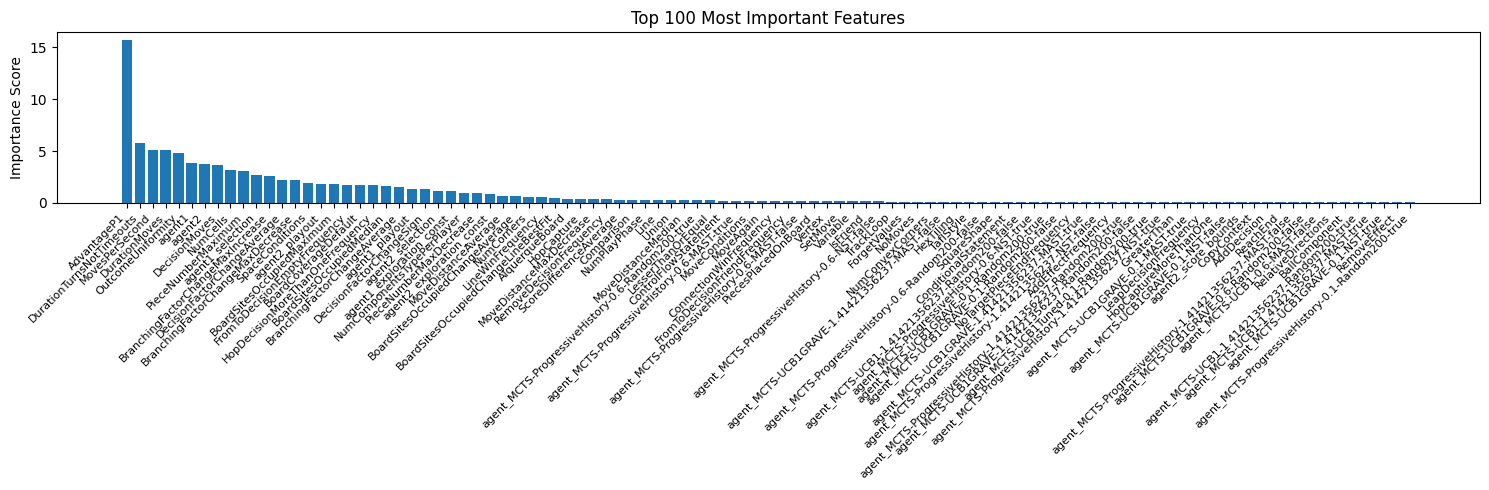

Fold 1 - RMSE: 0.42685755177921436
Fold 2


0:	learn: 0.6061769	test: 0.5817494	best: 0.5817494 (0)	total: 73.7ms	remaining: 3m 40s


50:	learn: 0.3970039	test: 0.4712637	best: 0.4712637 (50)	total: 3.61s	remaining: 3m 28s


100:	learn: 0.3548188	test: 0.4539460	best: 0.4537432 (99)	total: 7.39s	remaining: 3m 32s


150:	learn: 0.3307689	test: 0.4474873	best: 0.4474873 (150)	total: 11.1s	remaining: 3m 30s


200:	learn: 0.3154200	test: 0.4445099	best: 0.4445099 (200)	total: 15s	remaining: 3m 28s


250:	learn: 0.3041340	test: 0.4418680	best: 0.4418680 (250)	total: 18.8s	remaining: 3m 25s


300:	learn: 0.2940708	test: 0.4407226	best: 0.4404672 (295)	total: 22.6s	remaining: 3m 22s


350:	learn: 0.2864795	test: 0.4392467	best: 0.4392467 (350)	total: 26.5s	remaining: 3m 20s


400:	learn: 0.2796468	test: 0.4379448	best: 0.4379448 (400)	total: 30.4s	remaining: 3m 16s


450:	learn: 0.2739488	test: 0.4372032	best: 0.4372032 (450)	total: 34.3s	remaining: 3m 13s


500:	learn: 0.2688890	test: 0.4366826	best: 0.4366692 (497)	total: 38.2s	remaining: 3m 10s


550:	learn: 0.2640719	test: 0.4360699	best: 0.4359339 (540)	total: 42.1s	remaining: 3m 7s


600:	learn: 0.2596124	test: 0.4355641	best: 0.4355423 (599)	total: 46s	remaining: 3m 3s


650:	learn: 0.2555917	test: 0.4350850	best: 0.4350850 (650)	total: 49.9s	remaining: 2m 59s


700:	learn: 0.2518546	test: 0.4343348	best: 0.4343348 (700)	total: 53.8s	remaining: 2m 56s


750:	learn: 0.2482318	test: 0.4341257	best: 0.4341257 (750)	total: 57.7s	remaining: 2m 52s


800:	learn: 0.2448239	test: 0.4338493	best: 0.4338493 (800)	total: 1m 1s	remaining: 2m 49s


850:	learn: 0.2416887	test: 0.4336207	best: 0.4335627 (844)	total: 1m 5s	remaining: 2m 45s


900:	learn: 0.2387209	test: 0.4336295	best: 0.4335485 (870)	total: 1m 9s	remaining: 2m 41s


950:	learn: 0.2361762	test: 0.4333578	best: 0.4333504 (945)	total: 1m 13s	remaining: 2m 38s


1000:	learn: 0.2334391	test: 0.4332929	best: 0.4331885 (988)	total: 1m 17s	remaining: 2m 34s


1050:	learn: 0.2308140	test: 0.4331987	best: 0.4331681 (1020)	total: 1m 21s	remaining: 2m 31s


1100:	learn: 0.2285024	test: 0.4330286	best: 0.4330044 (1096)	total: 1m 25s	remaining: 2m 27s


1150:	learn: 0.2261613	test: 0.4329091	best: 0.4329055 (1142)	total: 1m 29s	remaining: 2m 23s


1200:	learn: 0.2238577	test: 0.4328773	best: 0.4328682 (1173)	total: 1m 33s	remaining: 2m 19s


1250:	learn: 0.2217093	test: 0.4327292	best: 0.4327271 (1249)	total: 1m 37s	remaining: 2m 16s


1300:	learn: 0.2194329	test: 0.4327843	best: 0.4327271 (1249)	total: 1m 41s	remaining: 2m 12s


1350:	learn: 0.2174573	test: 0.4327164	best: 0.4326635 (1332)	total: 1m 45s	remaining: 2m 8s


1400:	learn: 0.2154346	test: 0.4327285	best: 0.4326635 (1332)	total: 1m 49s	remaining: 2m 4s


1450:	learn: 0.2136379	test: 0.4326323	best: 0.4325946 (1447)	total: 1m 53s	remaining: 2m 1s


1500:	learn: 0.2115337	test: 0.4325009	best: 0.4324989 (1499)	total: 1m 57s	remaining: 1m 57s


1550:	learn: 0.2096590	test: 0.4324869	best: 0.4324615 (1543)	total: 2m 1s	remaining: 1m 53s


1600:	learn: 0.2078940	test: 0.4323356	best: 0.4323356 (1600)	total: 2m 5s	remaining: 1m 49s


1650:	learn: 0.2062103	test: 0.4324489	best: 0.4323226 (1604)	total: 2m 9s	remaining: 1m 45s


1700:	learn: 0.2046196	test: 0.4323902	best: 0.4323226 (1604)	total: 2m 13s	remaining: 1m 41s


1750:	learn: 0.2029399	test: 0.4324909	best: 0.4323226 (1604)	total: 2m 17s	remaining: 1m 38s


1800:	learn: 0.2014651	test: 0.4323501	best: 0.4323226 (1604)	total: 2m 21s	remaining: 1m 34s


1850:	learn: 0.1999310	test: 0.4323020	best: 0.4322989 (1832)	total: 2m 25s	remaining: 1m 30s


1900:	learn: 0.1983880	test: 0.4322553	best: 0.4322493 (1879)	total: 2m 29s	remaining: 1m 26s


1950:	learn: 0.1969184	test: 0.4323060	best: 0.4322191 (1914)	total: 2m 33s	remaining: 1m 22s


2000:	learn: 0.1952686	test: 0.4322255	best: 0.4321999 (1984)	total: 2m 37s	remaining: 1m 18s


2050:	learn: 0.1938802	test: 0.4322332	best: 0.4321999 (1984)	total: 2m 41s	remaining: 1m 14s


2100:	learn: 0.1925026	test: 0.4320905	best: 0.4320836 (2097)	total: 2m 45s	remaining: 1m 10s


2150:	learn: 0.1910988	test: 0.4320119	best: 0.4319870 (2142)	total: 2m 49s	remaining: 1m 7s


2200:	learn: 0.1897701	test: 0.4320671	best: 0.4319870 (2142)	total: 2m 54s	remaining: 1m 3s


2250:	learn: 0.1884927	test: 0.4319688	best: 0.4319574 (2243)	total: 2m 58s	remaining: 59.3s


2300:	learn: 0.1871149	test: 0.4319480	best: 0.4319300 (2284)	total: 3m 2s	remaining: 55.3s


2350:	learn: 0.1857355	test: 0.4319179	best: 0.4319179 (2350)	total: 3m 6s	remaining: 51.4s


2400:	learn: 0.1845149	test: 0.4318856	best: 0.4318849 (2398)	total: 3m 10s	remaining: 47.5s


2450:	learn: 0.1832282	test: 0.4318423	best: 0.4318285 (2431)	total: 3m 14s	remaining: 43.5s


2500:	learn: 0.1820266	test: 0.4317794	best: 0.4317680 (2481)	total: 3m 18s	remaining: 39.6s


2550:	learn: 0.1808672	test: 0.4317673	best: 0.4317354 (2520)	total: 3m 22s	remaining: 35.7s


2600:	learn: 0.1796935	test: 0.4318320	best: 0.4317354 (2520)	total: 3m 26s	remaining: 31.7s


2650:	learn: 0.1784231	test: 0.4318442	best: 0.4317354 (2520)	total: 3m 30s	remaining: 27.7s


2700:	learn: 0.1772821	test: 0.4318900	best: 0.4317354 (2520)	total: 3m 34s	remaining: 23.8s


2750:	learn: 0.1761667	test: 0.4317698	best: 0.4317354 (2520)	total: 3m 38s	remaining: 19.8s


2800:	learn: 0.1750085	test: 0.4318047	best: 0.4317354 (2520)	total: 3m 43s	remaining: 15.8s


2850:	learn: 0.1738242	test: 0.4318621	best: 0.4317354 (2520)	total: 3m 47s	remaining: 11.9s


2900:	learn: 0.1727807	test: 0.4318929	best: 0.4317354 (2520)	total: 3m 51s	remaining: 7.89s


2950:	learn: 0.1718338	test: 0.4319235	best: 0.4317354 (2520)	total: 3m 55s	remaining: 3.91s


2999:	learn: 0.1708059	test: 0.4319652	best: 0.4317354 (2520)	total: 3m 59s	remaining: 0us

bestTest = 0.4317354261
bestIteration = 2520

Shrink model to first 2521 iterations.


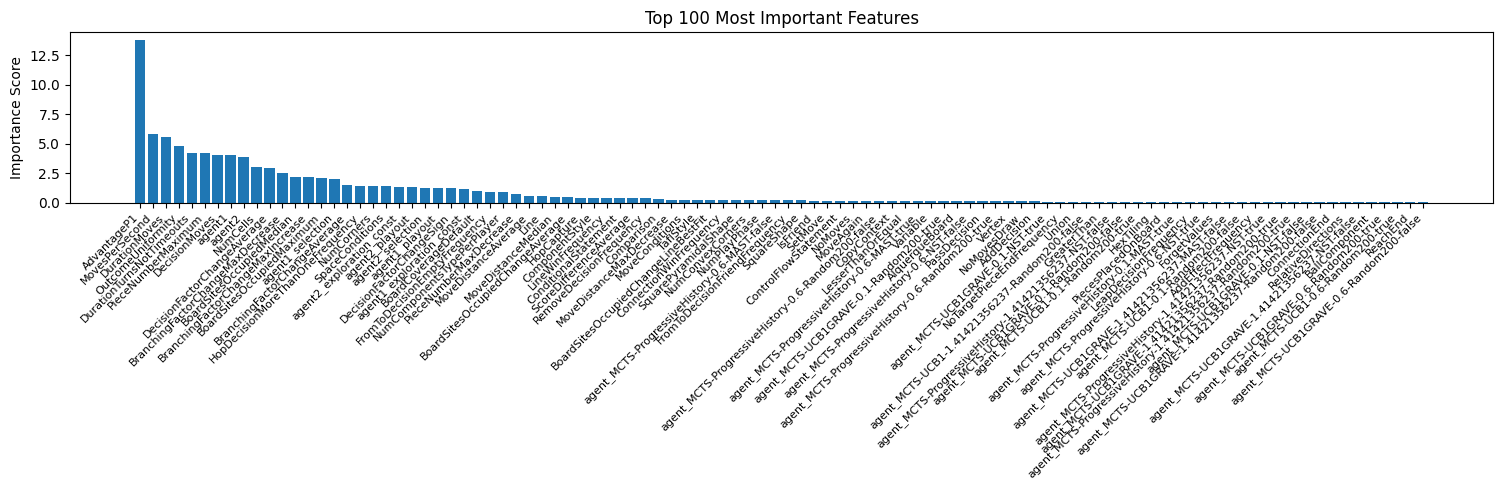

Fold 2 - RMSE: 0.4311337752700631
Fold 3


0:	learn: 0.6054192	test: 0.5952297	best: 0.5952297 (0)	total: 75.2ms	remaining: 3m 45s


50:	learn: 0.3954739	test: 0.4658729	best: 0.4658192 (48)	total: 3.81s	remaining: 3m 40s


100:	learn: 0.3540358	test: 0.4505109	best: 0.4505109 (100)	total: 7.78s	remaining: 3m 43s


150:	learn: 0.3318281	test: 0.4427814	best: 0.4427814 (150)	total: 11.8s	remaining: 3m 41s


200:	learn: 0.3165319	test: 0.4392043	best: 0.4392043 (200)	total: 15.7s	remaining: 3m 39s


250:	learn: 0.3045354	test: 0.4380724	best: 0.4380724 (250)	total: 19.7s	remaining: 3m 36s


300:	learn: 0.2937311	test: 0.4363132	best: 0.4362026 (298)	total: 23.7s	remaining: 3m 32s


350:	learn: 0.2846805	test: 0.4348983	best: 0.4348615 (349)	total: 27.7s	remaining: 3m 29s


400:	learn: 0.2774101	test: 0.4334796	best: 0.4334796 (400)	total: 31.7s	remaining: 3m 25s


450:	learn: 0.2716544	test: 0.4330404	best: 0.4328237 (436)	total: 36s	remaining: 3m 23s


500:	learn: 0.2666171	test: 0.4319974	best: 0.4319974 (500)	total: 40.4s	remaining: 3m 21s


550:	learn: 0.2615563	test: 0.4314876	best: 0.4314813 (549)	total: 44.6s	remaining: 3m 18s


600:	learn: 0.2573660	test: 0.4312801	best: 0.4312801 (600)	total: 48.7s	remaining: 3m 14s


650:	learn: 0.2536038	test: 0.4308395	best: 0.4308372 (646)	total: 52.9s	remaining: 3m 10s


700:	learn: 0.2498941	test: 0.4306533	best: 0.4306195 (691)	total: 57s	remaining: 3m 7s


750:	learn: 0.2463908	test: 0.4301727	best: 0.4301727 (750)	total: 1m 1s	remaining: 3m 3s


800:	learn: 0.2429693	test: 0.4301105	best: 0.4300740 (786)	total: 1m 5s	remaining: 2m 59s


850:	learn: 0.2396886	test: 0.4296154	best: 0.4295946 (848)	total: 1m 10s	remaining: 2m 56s


900:	learn: 0.2369155	test: 0.4293126	best: 0.4292973 (890)	total: 1m 15s	remaining: 2m 54s


950:	learn: 0.2341872	test: 0.4292331	best: 0.4291897 (942)	total: 1m 20s	remaining: 2m 52s


1000:	learn: 0.2315544	test: 0.4291406	best: 0.4291108 (969)	total: 1m 24s	remaining: 2m 48s


1050:	learn: 0.2289606	test: 0.4288946	best: 0.4288946 (1050)	total: 1m 28s	remaining: 2m 44s


1100:	learn: 0.2267173	test: 0.4285699	best: 0.4285699 (1100)	total: 1m 32s	remaining: 2m 39s


1150:	learn: 0.2243942	test: 0.4283043	best: 0.4283043 (1150)	total: 1m 36s	remaining: 2m 35s


1200:	learn: 0.2222076	test: 0.4282708	best: 0.4281852 (1191)	total: 1m 40s	remaining: 2m 31s


1250:	learn: 0.2199839	test: 0.4282692	best: 0.4281852 (1191)	total: 1m 45s	remaining: 2m 26s


1300:	learn: 0.2179849	test: 0.4281657	best: 0.4281647 (1283)	total: 1m 49s	remaining: 2m 22s


1350:	learn: 0.2160080	test: 0.4281967	best: 0.4281103 (1320)	total: 1m 53s	remaining: 2m 18s


1400:	learn: 0.2139796	test: 0.4280480	best: 0.4280211 (1398)	total: 1m 57s	remaining: 2m 14s


1450:	learn: 0.2122394	test: 0.4279679	best: 0.4279634 (1449)	total: 2m 1s	remaining: 2m 9s


1500:	learn: 0.2104512	test: 0.4280641	best: 0.4279634 (1449)	total: 2m 5s	remaining: 2m 5s


1550:	learn: 0.2086428	test: 0.4279929	best: 0.4279634 (1449)	total: 2m 9s	remaining: 2m 1s


1600:	learn: 0.2071075	test: 0.4278729	best: 0.4278510 (1591)	total: 2m 13s	remaining: 1m 57s


1650:	learn: 0.2054205	test: 0.4278925	best: 0.4278510 (1591)	total: 2m 18s	remaining: 1m 52s


1700:	learn: 0.2037451	test: 0.4278934	best: 0.4278452 (1671)	total: 2m 22s	remaining: 1m 48s


1750:	learn: 0.2020125	test: 0.4278602	best: 0.4278340 (1744)	total: 2m 26s	remaining: 1m 44s


1800:	learn: 0.2005011	test: 0.4279738	best: 0.4278340 (1744)	total: 2m 30s	remaining: 1m 40s


1850:	learn: 0.1989749	test: 0.4278476	best: 0.4278340 (1744)	total: 2m 34s	remaining: 1m 36s


1900:	learn: 0.1975764	test: 0.4278199	best: 0.4278199 (1900)	total: 2m 38s	remaining: 1m 31s


1950:	learn: 0.1959850	test: 0.4277818	best: 0.4277614 (1915)	total: 2m 43s	remaining: 1m 27s


2000:	learn: 0.1944619	test: 0.4277099	best: 0.4276813 (1997)	total: 2m 47s	remaining: 1m 23s


2050:	learn: 0.1930151	test: 0.4276920	best: 0.4276456 (2034)	total: 2m 51s	remaining: 1m 19s


2100:	learn: 0.1915712	test: 0.4276231	best: 0.4276231 (2100)	total: 2m 55s	remaining: 1m 15s


2150:	learn: 0.1902094	test: 0.4276690	best: 0.4276051 (2120)	total: 2m 59s	remaining: 1m 10s


2200:	learn: 0.1888939	test: 0.4277064	best: 0.4276051 (2120)	total: 3m 3s	remaining: 1m 6s


2250:	learn: 0.1876391	test: 0.4275945	best: 0.4275850 (2247)	total: 3m 8s	remaining: 1m 2s


2300:	learn: 0.1864137	test: 0.4275937	best: 0.4275792 (2258)	total: 3m 12s	remaining: 58.4s


2350:	learn: 0.1851429	test: 0.4276496	best: 0.4275792 (2258)	total: 3m 16s	remaining: 54.3s


2400:	learn: 0.1838747	test: 0.4277056	best: 0.4275792 (2258)	total: 3m 21s	remaining: 50.2s


2450:	learn: 0.1827027	test: 0.4276281	best: 0.4275792 (2258)	total: 3m 25s	remaining: 46s


2500:	learn: 0.1814590	test: 0.4276340	best: 0.4275792 (2258)	total: 3m 29s	remaining: 41.9s


2550:	learn: 0.1802582	test: 0.4276340	best: 0.4275792 (2258)	total: 3m 34s	remaining: 37.7s


2600:	learn: 0.1790458	test: 0.4274847	best: 0.4274847 (2600)	total: 3m 38s	remaining: 33.5s


2650:	learn: 0.1778308	test: 0.4274954	best: 0.4274783 (2607)	total: 3m 42s	remaining: 29.3s


2700:	learn: 0.1766137	test: 0.4274735	best: 0.4274483 (2670)	total: 3m 46s	remaining: 25.1s


2750:	learn: 0.1754796	test: 0.4274464	best: 0.4274464 (2750)	total: 3m 51s	remaining: 20.9s


2800:	learn: 0.1744473	test: 0.4275085	best: 0.4274455 (2752)	total: 3m 55s	remaining: 16.7s


2850:	learn: 0.1733259	test: 0.4275059	best: 0.4274455 (2752)	total: 3m 59s	remaining: 12.5s


2900:	learn: 0.1721763	test: 0.4275676	best: 0.4274455 (2752)	total: 4m 3s	remaining: 8.31s


2950:	learn: 0.1710834	test: 0.4275553	best: 0.4274455 (2752)	total: 4m 7s	remaining: 4.11s


2999:	learn: 0.1700225	test: 0.4276326	best: 0.4274455 (2752)	total: 4m 11s	remaining: 0us

bestTest = 0.4274455341
bestIteration = 2752

Shrink model to first 2753 iterations.


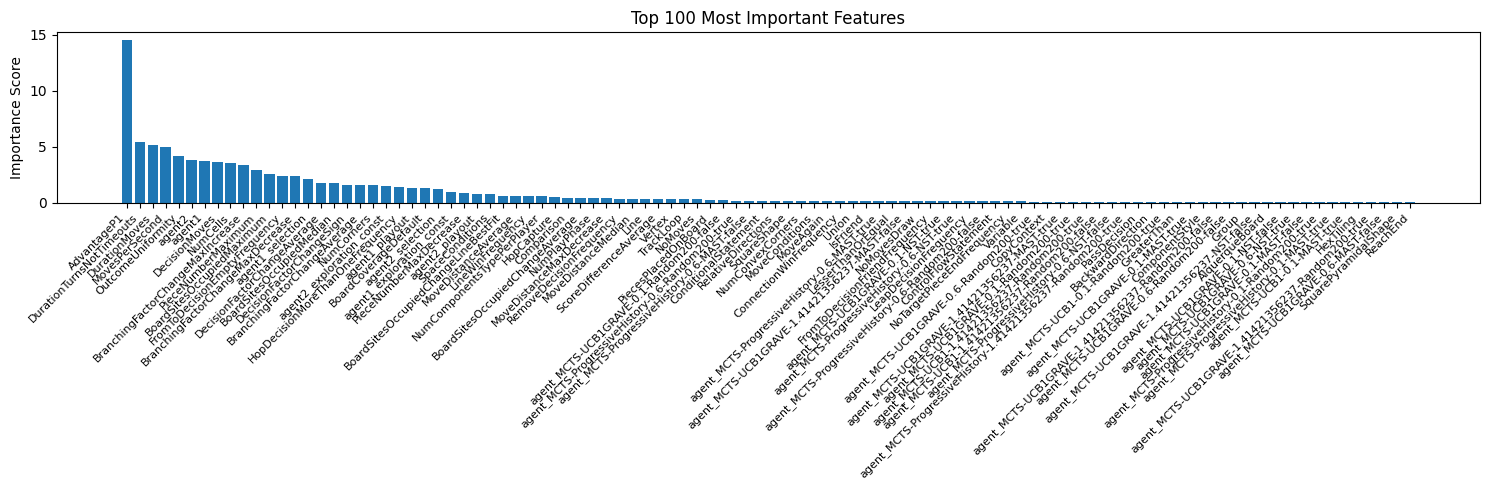

Fold 3 - RMSE: 0.4264250880979833
Fold 4


0:	learn: 0.6050083	test: 0.5884788	best: 0.5884788 (0)	total: 75.9ms	remaining: 3m 47s


50:	learn: 0.3909090	test: 0.4820077	best: 0.4820077 (50)	total: 3.65s	remaining: 3m 30s


100:	learn: 0.3504761	test: 0.4592173	best: 0.4592173 (100)	total: 7.61s	remaining: 3m 38s


150:	learn: 0.3280392	test: 0.4516075	best: 0.4516075 (150)	total: 11.5s	remaining: 3m 37s


200:	learn: 0.3123038	test: 0.4470158	best: 0.4470158 (200)	total: 15.5s	remaining: 3m 35s


250:	learn: 0.3007527	test: 0.4449545	best: 0.4449545 (250)	total: 19.5s	remaining: 3m 33s


300:	learn: 0.2917251	test: 0.4430177	best: 0.4430177 (300)	total: 23.5s	remaining: 3m 31s


350:	learn: 0.2837762	test: 0.4421154	best: 0.4421154 (350)	total: 27.6s	remaining: 3m 27s


400:	learn: 0.2765522	test: 0.4411645	best: 0.4411645 (400)	total: 31.6s	remaining: 3m 24s


450:	learn: 0.2703612	test: 0.4405287	best: 0.4405177 (442)	total: 35.6s	remaining: 3m 21s


500:	learn: 0.2651756	test: 0.4396157	best: 0.4396157 (500)	total: 39.6s	remaining: 3m 17s


550:	learn: 0.2602711	test: 0.4389548	best: 0.4389548 (550)	total: 43.7s	remaining: 3m 14s


600:	learn: 0.2565266	test: 0.4382083	best: 0.4382058 (599)	total: 47.8s	remaining: 3m 10s


650:	learn: 0.2528282	test: 0.4378697	best: 0.4378421 (648)	total: 51.9s	remaining: 3m 7s


700:	learn: 0.2492089	test: 0.4375035	best: 0.4375035 (700)	total: 56s	remaining: 3m 3s


750:	learn: 0.2458015	test: 0.4370401	best: 0.4370251 (747)	total: 1m	remaining: 2m 59s


800:	learn: 0.2426978	test: 0.4368996	best: 0.4368978 (798)	total: 1m 4s	remaining: 2m 56s


850:	learn: 0.2394785	test: 0.4366888	best: 0.4366888 (850)	total: 1m 8s	remaining: 2m 52s


900:	learn: 0.2366268	test: 0.4365686	best: 0.4365166 (884)	total: 1m 12s	remaining: 2m 49s


950:	learn: 0.2339797	test: 0.4364474	best: 0.4364474 (950)	total: 1m 16s	remaining: 2m 45s


1000:	learn: 0.2315243	test: 0.4361174	best: 0.4361174 (1000)	total: 1m 20s	remaining: 2m 41s


1050:	learn: 0.2290585	test: 0.4360252	best: 0.4360241 (1049)	total: 1m 24s	remaining: 2m 37s


1100:	learn: 0.2265989	test: 0.4357517	best: 0.4357140 (1083)	total: 1m 29s	remaining: 2m 33s


1150:	learn: 0.2244055	test: 0.4356838	best: 0.4356060 (1138)	total: 1m 33s	remaining: 2m 29s


1200:	learn: 0.2222394	test: 0.4356552	best: 0.4356060 (1138)	total: 1m 37s	remaining: 2m 25s


1250:	learn: 0.2198874	test: 0.4354831	best: 0.4354333 (1246)	total: 1m 41s	remaining: 2m 21s


1300:	learn: 0.2175355	test: 0.4354070	best: 0.4353089 (1278)	total: 1m 45s	remaining: 2m 17s


1350:	learn: 0.2155797	test: 0.4353348	best: 0.4353022 (1332)	total: 1m 49s	remaining: 2m 13s


1400:	learn: 0.2136422	test: 0.4351162	best: 0.4351050 (1397)	total: 1m 53s	remaining: 2m 9s


1450:	learn: 0.2118037	test: 0.4350693	best: 0.4350638 (1446)	total: 1m 57s	remaining: 2m 5s


1500:	learn: 0.2101106	test: 0.4348300	best: 0.4348207 (1499)	total: 2m 1s	remaining: 2m 1s


1550:	learn: 0.2083362	test: 0.4346648	best: 0.4346648 (1550)	total: 2m 5s	remaining: 1m 57s


1600:	learn: 0.2068576	test: 0.4345181	best: 0.4345181 (1600)	total: 2m 9s	remaining: 1m 53s


1650:	learn: 0.2052339	test: 0.4345161	best: 0.4344733 (1623)	total: 2m 13s	remaining: 1m 49s


1700:	learn: 0.2036507	test: 0.4345945	best: 0.4344733 (1623)	total: 2m 17s	remaining: 1m 45s


1750:	learn: 0.2019554	test: 0.4344554	best: 0.4344554 (1750)	total: 2m 21s	remaining: 1m 41s


1800:	learn: 0.2003863	test: 0.4344827	best: 0.4344133 (1762)	total: 2m 25s	remaining: 1m 37s


1850:	learn: 0.1987520	test: 0.4345134	best: 0.4344133 (1762)	total: 2m 29s	remaining: 1m 33s


1900:	learn: 0.1972024	test: 0.4345825	best: 0.4344133 (1762)	total: 2m 33s	remaining: 1m 28s


1950:	learn: 0.1957804	test: 0.4345156	best: 0.4344133 (1762)	total: 2m 37s	remaining: 1m 24s


2000:	learn: 0.1943225	test: 0.4344656	best: 0.4344133 (1762)	total: 2m 41s	remaining: 1m 20s


2050:	learn: 0.1928759	test: 0.4344381	best: 0.4343891 (2029)	total: 2m 45s	remaining: 1m 16s


2100:	learn: 0.1914293	test: 0.4343213	best: 0.4343212 (2099)	total: 2m 49s	remaining: 1m 12s


2150:	learn: 0.1900645	test: 0.4342763	best: 0.4342717 (2138)	total: 2m 54s	remaining: 1m 8s


2200:	learn: 0.1886119	test: 0.4342948	best: 0.4342717 (2138)	total: 2m 58s	remaining: 1m 4s


2250:	learn: 0.1872453	test: 0.4342982	best: 0.4342717 (2138)	total: 3m 2s	remaining: 1m


2300:	learn: 0.1859804	test: 0.4342898	best: 0.4342700 (2291)	total: 3m 6s	remaining: 56.6s


2350:	learn: 0.1846704	test: 0.4342825	best: 0.4342469 (2319)	total: 3m 10s	remaining: 52.5s


2400:	learn: 0.1834730	test: 0.4342738	best: 0.4342438 (2364)	total: 3m 14s	remaining: 48.5s


2450:	learn: 0.1822150	test: 0.4342793	best: 0.4342438 (2364)	total: 3m 18s	remaining: 44.4s


2500:	learn: 0.1809195	test: 0.4342601	best: 0.4342348 (2476)	total: 3m 22s	remaining: 40.3s


2550:	learn: 0.1796358	test: 0.4342602	best: 0.4342348 (2476)	total: 3m 26s	remaining: 36.3s


2600:	learn: 0.1783945	test: 0.4342217	best: 0.4342217 (2600)	total: 3m 30s	remaining: 32.3s


2650:	learn: 0.1772415	test: 0.4341325	best: 0.4341310 (2649)	total: 3m 34s	remaining: 28.2s


2700:	learn: 0.1760847	test: 0.4341146	best: 0.4341113 (2699)	total: 3m 38s	remaining: 24.2s


2750:	learn: 0.1749672	test: 0.4340885	best: 0.4340794 (2725)	total: 3m 42s	remaining: 20.1s


2800:	learn: 0.1739563	test: 0.4340448	best: 0.4340448 (2800)	total: 3m 46s	remaining: 16.1s


2850:	learn: 0.1729102	test: 0.4340312	best: 0.4339921 (2816)	total: 3m 50s	remaining: 12.1s


2900:	learn: 0.1718757	test: 0.4340625	best: 0.4339921 (2816)	total: 3m 55s	remaining: 8.02s


2950:	learn: 0.1707161	test: 0.4340857	best: 0.4339921 (2816)	total: 3m 59s	remaining: 3.97s


2999:	learn: 0.1696710	test: 0.4340439	best: 0.4339921 (2816)	total: 4m 3s	remaining: 0us

bestTest = 0.4339921289
bestIteration = 2816

Shrink model to first 2817 iterations.


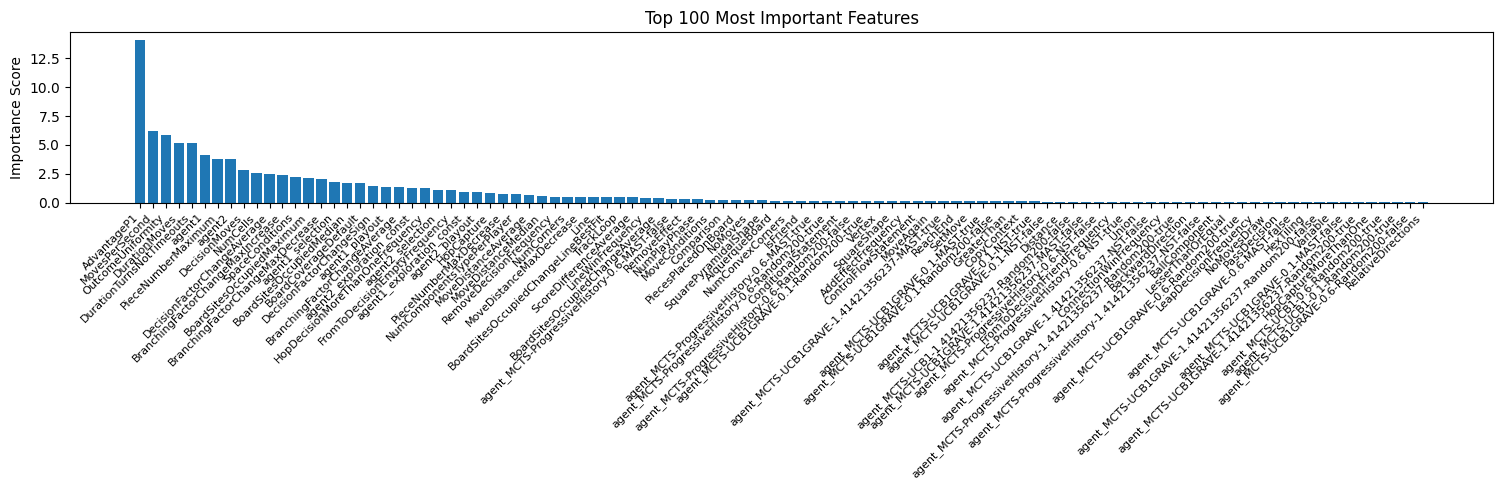

Fold 4 - RMSE: 0.43331265981351247
Fold 5


0:	learn: 0.6168514	test: 0.5447507	best: 0.5447507 (0)	total: 61.2ms	remaining: 3m 3s


50:	learn: 0.3998903	test: 0.4528892	best: 0.4528892 (50)	total: 3.72s	remaining: 3m 35s


100:	learn: 0.3581780	test: 0.4300051	best: 0.4300051 (100)	total: 7.62s	remaining: 3m 38s


150:	learn: 0.3359335	test: 0.4213737	best: 0.4213737 (150)	total: 11.5s	remaining: 3m 36s


200:	learn: 0.3200879	test: 0.4171819	best: 0.4171647 (199)	total: 15.4s	remaining: 3m 34s


250:	learn: 0.3071823	test: 0.4143975	best: 0.4143829 (249)	total: 19.3s	remaining: 3m 30s


300:	learn: 0.2971677	test: 0.4128513	best: 0.4128513 (300)	total: 23.2s	remaining: 3m 28s


350:	learn: 0.2888196	test: 0.4115668	best: 0.4115614 (349)	total: 27.1s	remaining: 3m 24s


400:	learn: 0.2819376	test: 0.4101475	best: 0.4101357 (399)	total: 31.1s	remaining: 3m 21s


450:	learn: 0.2759570	test: 0.4091293	best: 0.4090863 (446)	total: 35s	remaining: 3m 17s


500:	learn: 0.2701402	test: 0.4081767	best: 0.4081693 (496)	total: 38.8s	remaining: 3m 13s


550:	learn: 0.2653719	test: 0.4080031	best: 0.4079965 (525)	total: 42.7s	remaining: 3m 9s


600:	learn: 0.2608564	test: 0.4075150	best: 0.4075042 (598)	total: 46.7s	remaining: 3m 6s


650:	learn: 0.2565842	test: 0.4074449	best: 0.4072994 (621)	total: 50.6s	remaining: 3m 2s


700:	learn: 0.2525973	test: 0.4071932	best: 0.4071932 (700)	total: 54.5s	remaining: 2m 58s


750:	learn: 0.2489662	test: 0.4071116	best: 0.4070528 (745)	total: 58.5s	remaining: 2m 55s


800:	learn: 0.2452499	test: 0.4073023	best: 0.4070528 (745)	total: 1m 2s	remaining: 2m 51s


850:	learn: 0.2417832	test: 0.4070458	best: 0.4069866 (844)	total: 1m 6s	remaining: 2m 47s


900:	learn: 0.2385046	test: 0.4067806	best: 0.4067392 (881)	total: 1m 10s	remaining: 2m 43s


950:	learn: 0.2358780	test: 0.4065288	best: 0.4065254 (947)	total: 1m 14s	remaining: 2m 40s


1000:	learn: 0.2335161	test: 0.4063448	best: 0.4063289 (999)	total: 1m 18s	remaining: 2m 36s


1050:	learn: 0.2308848	test: 0.4061586	best: 0.4061485 (1049)	total: 1m 22s	remaining: 2m 32s


1100:	learn: 0.2282303	test: 0.4060253	best: 0.4060229 (1099)	total: 1m 25s	remaining: 2m 28s


1150:	learn: 0.2260003	test: 0.4057064	best: 0.4057000 (1148)	total: 1m 29s	remaining: 2m 24s


1200:	learn: 0.2238299	test: 0.4056895	best: 0.4056050 (1176)	total: 1m 33s	remaining: 2m 20s


1250:	learn: 0.2213982	test: 0.4055029	best: 0.4054918 (1248)	total: 1m 37s	remaining: 2m 16s


1300:	learn: 0.2193053	test: 0.4055540	best: 0.4054918 (1248)	total: 1m 41s	remaining: 2m 12s


1350:	learn: 0.2172602	test: 0.4055165	best: 0.4054806 (1341)	total: 1m 45s	remaining: 2m 8s


1400:	learn: 0.2152290	test: 0.4053615	best: 0.4053615 (1400)	total: 1m 49s	remaining: 2m 5s


1450:	learn: 0.2132343	test: 0.4053704	best: 0.4053615 (1400)	total: 1m 53s	remaining: 2m 1s


1500:	learn: 0.2112952	test: 0.4053124	best: 0.4052744 (1471)	total: 1m 57s	remaining: 1m 57s


1550:	learn: 0.2092876	test: 0.4053449	best: 0.4052744 (1471)	total: 2m 1s	remaining: 1m 53s


1600:	learn: 0.2075350	test: 0.4054070	best: 0.4052744 (1471)	total: 2m 5s	remaining: 1m 49s


1650:	learn: 0.2056694	test: 0.4052533	best: 0.4052439 (1642)	total: 2m 8s	remaining: 1m 45s


1700:	learn: 0.2038208	test: 0.4052633	best: 0.4052145 (1694)	total: 2m 12s	remaining: 1m 41s


1750:	learn: 0.2020655	test: 0.4052986	best: 0.4052145 (1694)	total: 2m 16s	remaining: 1m 37s


1800:	learn: 0.2004364	test: 0.4053079	best: 0.4052145 (1694)	total: 2m 20s	remaining: 1m 33s


1850:	learn: 0.1990037	test: 0.4053181	best: 0.4052145 (1694)	total: 2m 24s	remaining: 1m 29s


1900:	learn: 0.1975617	test: 0.4053425	best: 0.4052145 (1694)	total: 2m 28s	remaining: 1m 25s


1950:	learn: 0.1960479	test: 0.4053544	best: 0.4052145 (1694)	total: 2m 32s	remaining: 1m 21s


2000:	learn: 0.1944200	test: 0.4053169	best: 0.4052145 (1694)	total: 2m 36s	remaining: 1m 17s


2050:	learn: 0.1929035	test: 0.4053816	best: 0.4052145 (1694)	total: 2m 40s	remaining: 1m 14s


2100:	learn: 0.1914374	test: 0.4053763	best: 0.4052145 (1694)	total: 2m 44s	remaining: 1m 10s


2150:	learn: 0.1901313	test: 0.4053125	best: 0.4052145 (1694)	total: 2m 49s	remaining: 1m 6s


2200:	learn: 0.1885960	test: 0.4053408	best: 0.4052145 (1694)	total: 2m 53s	remaining: 1m 2s


2250:	learn: 0.1873019	test: 0.4053072	best: 0.4052145 (1694)	total: 2m 57s	remaining: 59.1s


2300:	learn: 0.1860186	test: 0.4052929	best: 0.4052145 (1694)	total: 3m 1s	remaining: 55.2s


2350:	learn: 0.1845312	test: 0.4052666	best: 0.4052145 (1694)	total: 3m 5s	remaining: 51.2s


2400:	learn: 0.1833246	test: 0.4051341	best: 0.4051341 (2400)	total: 3m 9s	remaining: 47.3s


2450:	learn: 0.1820087	test: 0.4050809	best: 0.4050722 (2447)	total: 3m 13s	remaining: 43.4s


2500:	learn: 0.1805875	test: 0.4050532	best: 0.4050381 (2483)	total: 3m 17s	remaining: 39.5s


2550:	learn: 0.1792050	test: 0.4050379	best: 0.4050355 (2549)	total: 3m 21s	remaining: 35.6s


2600:	learn: 0.1780239	test: 0.4050712	best: 0.4050249 (2553)	total: 3m 26s	remaining: 31.6s


2650:	learn: 0.1767230	test: 0.4051674	best: 0.4050249 (2553)	total: 3m 30s	remaining: 27.7s


2700:	learn: 0.1755301	test: 0.4052256	best: 0.4050249 (2553)	total: 3m 34s	remaining: 23.7s


2750:	learn: 0.1744340	test: 0.4051930	best: 0.4050249 (2553)	total: 3m 38s	remaining: 19.8s


2800:	learn: 0.1732171	test: 0.4052143	best: 0.4050249 (2553)	total: 3m 42s	remaining: 15.8s


2850:	learn: 0.1720633	test: 0.4052245	best: 0.4050249 (2553)	total: 3m 46s	remaining: 11.9s


2900:	learn: 0.1709675	test: 0.4052429	best: 0.4050249 (2553)	total: 3m 51s	remaining: 7.89s


2950:	learn: 0.1698088	test: 0.4052466	best: 0.4050249 (2553)	total: 3m 55s	remaining: 3.91s


2999:	learn: 0.1687573	test: 0.4052062	best: 0.4050249 (2553)	total: 3m 59s	remaining: 0us

bestTest = 0.4050249106
bestIteration = 2553

Shrink model to first 2554 iterations.


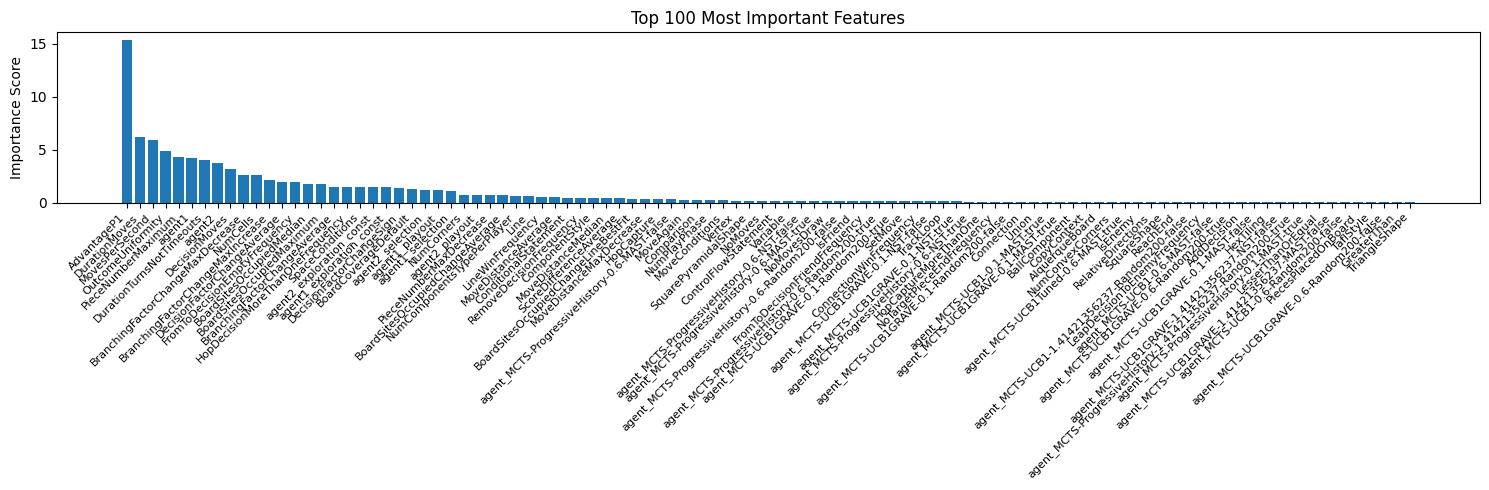

Fold 5 - RMSE: 0.40454584961867096
List of oof scores: [0.42685755177921436, 0.4311337752700631, 0.4264250880979833, 0.43331265981351247, 0.40454584961867096]
Average oof score: 0.42445498491588884


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_catboost_{fs_type}_cv1.parquet', index=False)

# save feature importance
# importance_df1.to_csv(path_results / 'feat_importance_catboost_cv1.csv', index=False)

Fold 1


0:	learn: 0.6189536	test: 0.5308721	best: 0.5308721 (0)	total: 74.3ms	remaining: 3m 42s


50:	learn: 0.3987011	test: 0.4505971	best: 0.4505971 (50)	total: 4.07s	remaining: 3m 55s


100:	learn: 0.3537679	test: 0.4347145	best: 0.4347145 (100)	total: 8.33s	remaining: 3m 59s


150:	learn: 0.3306053	test: 0.4283862	best: 0.4283862 (150)	total: 12.5s	remaining: 3m 55s


200:	learn: 0.3150359	test: 0.4255407	best: 0.4254870 (198)	total: 16.6s	remaining: 3m 50s


250:	learn: 0.3027209	test: 0.4233723	best: 0.4233723 (250)	total: 20.7s	remaining: 3m 46s


300:	learn: 0.2931032	test: 0.4214065	best: 0.4213424 (297)	total: 25s	remaining: 3m 44s


350:	learn: 0.2847842	test: 0.4208345	best: 0.4208119 (349)	total: 29.3s	remaining: 3m 40s


400:	learn: 0.2777297	test: 0.4199798	best: 0.4199798 (400)	total: 33.5s	remaining: 3m 37s


450:	learn: 0.2715796	test: 0.4192749	best: 0.4192324 (445)	total: 37.9s	remaining: 3m 34s


500:	learn: 0.2657066	test: 0.4188646	best: 0.4187951 (495)	total: 42s	remaining: 3m 29s


550:	learn: 0.2606776	test: 0.4184517	best: 0.4184193 (547)	total: 46.1s	remaining: 3m 25s


600:	learn: 0.2558225	test: 0.4180418	best: 0.4180418 (600)	total: 50.3s	remaining: 3m 20s


650:	learn: 0.2518091	test: 0.4176268	best: 0.4176058 (646)	total: 54.5s	remaining: 3m 16s


700:	learn: 0.2483389	test: 0.4175120	best: 0.4174979 (684)	total: 58.8s	remaining: 3m 12s


750:	learn: 0.2451134	test: 0.4174113	best: 0.4174113 (750)	total: 1m 3s	remaining: 3m 8s


800:	learn: 0.2418588	test: 0.4173060	best: 0.4172177 (785)	total: 1m 7s	remaining: 3m 4s


850:	learn: 0.2383275	test: 0.4171045	best: 0.4170943 (833)	total: 1m 11s	remaining: 3m


900:	learn: 0.2352892	test: 0.4168913	best: 0.4168893 (899)	total: 1m 15s	remaining: 2m 56s


950:	learn: 0.2326304	test: 0.4168789	best: 0.4168172 (925)	total: 1m 19s	remaining: 2m 52s


1000:	learn: 0.2298812	test: 0.4168044	best: 0.4167136 (988)	total: 1m 24s	remaining: 2m 48s


1050:	learn: 0.2274207	test: 0.4166880	best: 0.4166880 (1050)	total: 1m 28s	remaining: 2m 44s


1100:	learn: 0.2248254	test: 0.4165622	best: 0.4165328 (1079)	total: 1m 32s	remaining: 2m 40s


1150:	learn: 0.2224259	test: 0.4165035	best: 0.4164545 (1116)	total: 1m 37s	remaining: 2m 36s


1200:	learn: 0.2201596	test: 0.4166348	best: 0.4164545 (1116)	total: 1m 41s	remaining: 2m 32s


1250:	learn: 0.2178861	test: 0.4163964	best: 0.4163793 (1239)	total: 1m 45s	remaining: 2m 27s


1300:	learn: 0.2157926	test: 0.4162426	best: 0.4162403 (1298)	total: 1m 50s	remaining: 2m 23s


1350:	learn: 0.2137607	test: 0.4162070	best: 0.4161990 (1343)	total: 1m 54s	remaining: 2m 19s


1400:	learn: 0.2116235	test: 0.4162145	best: 0.4161777 (1353)	total: 1m 59s	remaining: 2m 15s


1450:	learn: 0.2096068	test: 0.4161856	best: 0.4161649 (1431)	total: 2m 3s	remaining: 2m 11s


1500:	learn: 0.2078689	test: 0.4161435	best: 0.4161307 (1462)	total: 2m 7s	remaining: 2m 7s


1550:	learn: 0.2058897	test: 0.4160613	best: 0.4160526 (1540)	total: 2m 12s	remaining: 2m 3s


1600:	learn: 0.2042126	test: 0.4160517	best: 0.4160506 (1598)	total: 2m 17s	remaining: 1m 59s


1650:	learn: 0.2024756	test: 0.4160833	best: 0.4160222 (1616)	total: 2m 21s	remaining: 1m 55s


1700:	learn: 0.2007884	test: 0.4160913	best: 0.4160222 (1616)	total: 2m 25s	remaining: 1m 51s


1750:	learn: 0.1990689	test: 0.4159595	best: 0.4159388 (1744)	total: 2m 30s	remaining: 1m 47s


1800:	learn: 0.1974229	test: 0.4158714	best: 0.4158714 (1800)	total: 2m 34s	remaining: 1m 43s


1850:	learn: 0.1958222	test: 0.4158742	best: 0.4158431 (1815)	total: 2m 39s	remaining: 1m 38s


1900:	learn: 0.1943437	test: 0.4157577	best: 0.4157495 (1890)	total: 2m 43s	remaining: 1m 34s


1950:	learn: 0.1929114	test: 0.4158322	best: 0.4157495 (1890)	total: 2m 48s	remaining: 1m 30s


2000:	learn: 0.1916426	test: 0.4157658	best: 0.4157495 (1890)	total: 2m 52s	remaining: 1m 26s


2050:	learn: 0.1902337	test: 0.4157346	best: 0.4157346 (2050)	total: 2m 57s	remaining: 1m 21s


2100:	learn: 0.1889335	test: 0.4157556	best: 0.4157027 (2079)	total: 3m 1s	remaining: 1m 17s


2150:	learn: 0.1875767	test: 0.4158234	best: 0.4157027 (2079)	total: 3m 6s	remaining: 1m 13s


2200:	learn: 0.1861459	test: 0.4157488	best: 0.4157027 (2079)	total: 3m 10s	remaining: 1m 9s


2250:	learn: 0.1849639	test: 0.4158154	best: 0.4157027 (2079)	total: 3m 15s	remaining: 1m 4s


2300:	learn: 0.1836015	test: 0.4158976	best: 0.4157027 (2079)	total: 3m 19s	remaining: 1m


2350:	learn: 0.1823495	test: 0.4158452	best: 0.4157027 (2079)	total: 3m 23s	remaining: 56.3s


2400:	learn: 0.1809788	test: 0.4158423	best: 0.4157027 (2079)	total: 3m 28s	remaining: 51.9s


2450:	learn: 0.1797951	test: 0.4158777	best: 0.4157027 (2079)	total: 3m 32s	remaining: 47.6s


2500:	learn: 0.1785795	test: 0.4158478	best: 0.4157027 (2079)	total: 3m 37s	remaining: 43.3s


2550:	learn: 0.1773230	test: 0.4158720	best: 0.4157027 (2079)	total: 3m 41s	remaining: 39s


2600:	learn: 0.1761197	test: 0.4159075	best: 0.4157027 (2079)	total: 3m 45s	remaining: 34.6s


2650:	learn: 0.1748878	test: 0.4159159	best: 0.4157027 (2079)	total: 3m 50s	remaining: 30.3s


2700:	learn: 0.1738043	test: 0.4158770	best: 0.4157027 (2079)	total: 3m 54s	remaining: 26s


2750:	learn: 0.1726681	test: 0.4159038	best: 0.4157027 (2079)	total: 3m 59s	remaining: 21.6s


2800:	learn: 0.1714570	test: 0.4159170	best: 0.4157027 (2079)	total: 4m 3s	remaining: 17.3s


2850:	learn: 0.1703475	test: 0.4159479	best: 0.4157027 (2079)	total: 4m 7s	remaining: 13s


2900:	learn: 0.1693021	test: 0.4159283	best: 0.4157027 (2079)	total: 4m 12s	remaining: 8.6s


2950:	learn: 0.1682162	test: 0.4159497	best: 0.4157027 (2079)	total: 4m 16s	remaining: 4.26s


2999:	learn: 0.1672105	test: 0.4159655	best: 0.4157027 (2079)	total: 4m 20s	remaining: 0us

bestTest = 0.4157026751
bestIteration = 2079

Shrink model to first 2080 iterations.


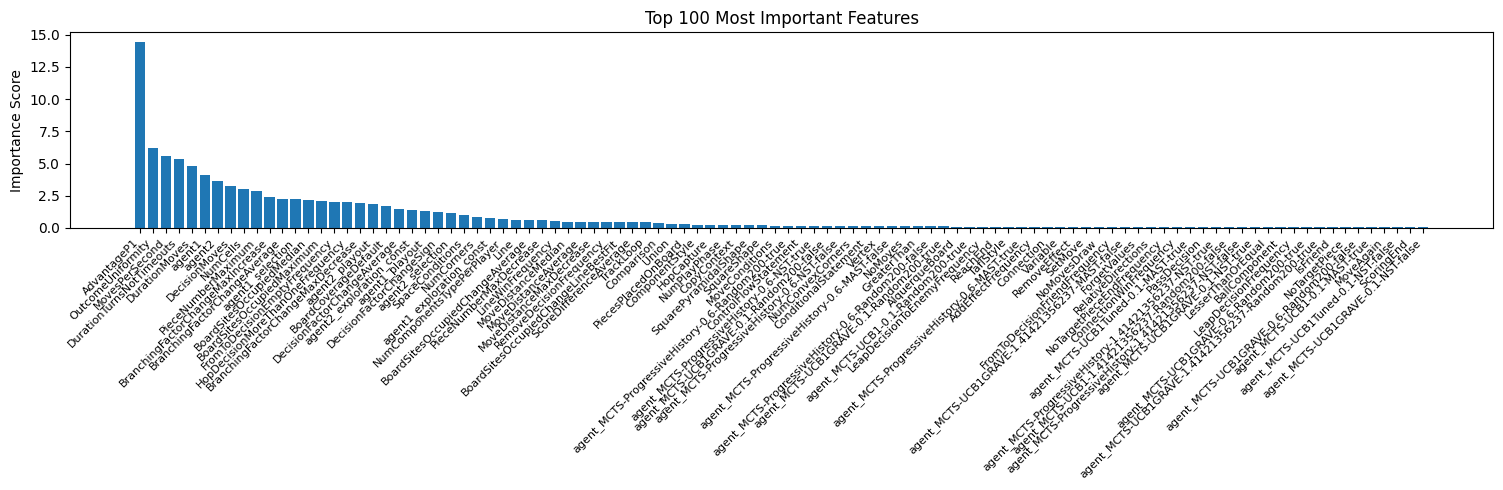

Fold 1 - RMSE: 0.4153090352637169
Fold 2


0:	learn: 0.6143552	test: 0.5370448	best: 0.5370448 (0)	total: 72.4ms	remaining: 3m 37s


50:	learn: 0.3956714	test: 0.4280419	best: 0.4280419 (50)	total: 4.23s	remaining: 4m 4s


100:	learn: 0.3538199	test: 0.4165632	best: 0.4165632 (100)	total: 8.42s	remaining: 4m 1s


150:	learn: 0.3293662	test: 0.4114401	best: 0.4114401 (150)	total: 12.6s	remaining: 3m 57s


200:	learn: 0.3132407	test: 0.4090612	best: 0.4090612 (200)	total: 16.9s	remaining: 3m 55s


250:	learn: 0.3013376	test: 0.4085527	best: 0.4085235 (249)	total: 21.1s	remaining: 3m 51s


300:	learn: 0.2916629	test: 0.4078106	best: 0.4078106 (300)	total: 25.4s	remaining: 3m 47s


350:	learn: 0.2836549	test: 0.4072336	best: 0.4072336 (350)	total: 29.9s	remaining: 3m 45s


400:	learn: 0.2769242	test: 0.4071373	best: 0.4069676 (389)	total: 34.2s	remaining: 3m 41s


450:	learn: 0.2705829	test: 0.4064541	best: 0.4064383 (447)	total: 38.5s	remaining: 3m 37s


500:	learn: 0.2647948	test: 0.4059311	best: 0.4059033 (498)	total: 42.7s	remaining: 3m 32s


550:	learn: 0.2599657	test: 0.4055968	best: 0.4055767 (549)	total: 47.4s	remaining: 3m 30s


600:	learn: 0.2557302	test: 0.4053179	best: 0.4053179 (600)	total: 52s	remaining: 3m 27s


650:	learn: 0.2509452	test: 0.4051574	best: 0.4051574 (650)	total: 56.6s	remaining: 3m 24s


700:	learn: 0.2472545	test: 0.4049160	best: 0.4048709 (699)	total: 1m 1s	remaining: 3m 20s


750:	learn: 0.2434478	test: 0.4049130	best: 0.4048709 (699)	total: 1m 5s	remaining: 3m 15s


800:	learn: 0.2399632	test: 0.4048515	best: 0.4047951 (776)	total: 1m 9s	remaining: 3m 10s


850:	learn: 0.2369692	test: 0.4047169	best: 0.4046832 (846)	total: 1m 13s	remaining: 3m 6s


900:	learn: 0.2342557	test: 0.4047026	best: 0.4046667 (895)	total: 1m 18s	remaining: 3m 1s


950:	learn: 0.2316754	test: 0.4047188	best: 0.4046205 (927)	total: 1m 22s	remaining: 2m 57s


1000:	learn: 0.2290923	test: 0.4046496	best: 0.4046205 (927)	total: 1m 26s	remaining: 2m 53s


1050:	learn: 0.2267105	test: 0.4046397	best: 0.4045784 (1022)	total: 1m 31s	remaining: 2m 49s


1100:	learn: 0.2243693	test: 0.4045549	best: 0.4045300 (1097)	total: 1m 35s	remaining: 2m 45s


1150:	learn: 0.2219196	test: 0.4046140	best: 0.4045300 (1097)	total: 1m 40s	remaining: 2m 40s


1200:	learn: 0.2199713	test: 0.4047195	best: 0.4045300 (1097)	total: 1m 44s	remaining: 2m 36s


1250:	learn: 0.2178741	test: 0.4047799	best: 0.4045300 (1097)	total: 1m 48s	remaining: 2m 31s


1300:	learn: 0.2158409	test: 0.4048463	best: 0.4045300 (1097)	total: 1m 52s	remaining: 2m 27s


1350:	learn: 0.2138720	test: 0.4045791	best: 0.4045300 (1097)	total: 1m 57s	remaining: 2m 23s


1400:	learn: 0.2118921	test: 0.4046578	best: 0.4045300 (1097)	total: 2m 1s	remaining: 2m 18s


1450:	learn: 0.2099273	test: 0.4046603	best: 0.4045300 (1097)	total: 2m 5s	remaining: 2m 14s


1500:	learn: 0.2082377	test: 0.4046130	best: 0.4045300 (1097)	total: 2m 10s	remaining: 2m 10s


1550:	learn: 0.2064483	test: 0.4046483	best: 0.4045300 (1097)	total: 2m 14s	remaining: 2m 5s


1600:	learn: 0.2046972	test: 0.4046722	best: 0.4045300 (1097)	total: 2m 18s	remaining: 2m 1s


1650:	learn: 0.2029554	test: 0.4046100	best: 0.4045300 (1097)	total: 2m 23s	remaining: 1m 57s


1700:	learn: 0.2011298	test: 0.4045831	best: 0.4045300 (1097)	total: 2m 27s	remaining: 1m 52s


1750:	learn: 0.1996021	test: 0.4046143	best: 0.4045300 (1097)	total: 2m 31s	remaining: 1m 48s


1800:	learn: 0.1978925	test: 0.4045561	best: 0.4045300 (1097)	total: 2m 36s	remaining: 1m 43s


1850:	learn: 0.1963732	test: 0.4046220	best: 0.4045297 (1811)	total: 2m 40s	remaining: 1m 39s


1900:	learn: 0.1948772	test: 0.4046969	best: 0.4045297 (1811)	total: 2m 44s	remaining: 1m 35s


1950:	learn: 0.1933760	test: 0.4047718	best: 0.4045297 (1811)	total: 2m 49s	remaining: 1m 30s


2000:	learn: 0.1919354	test: 0.4047927	best: 0.4045297 (1811)	total: 2m 53s	remaining: 1m 26s


2050:	learn: 0.1904065	test: 0.4047247	best: 0.4045297 (1811)	total: 2m 57s	remaining: 1m 22s


2100:	learn: 0.1890453	test: 0.4048093	best: 0.4045297 (1811)	total: 3m 2s	remaining: 1m 17s


2150:	learn: 0.1875962	test: 0.4047456	best: 0.4045297 (1811)	total: 3m 6s	remaining: 1m 13s


2200:	learn: 0.1862970	test: 0.4047622	best: 0.4045297 (1811)	total: 3m 10s	remaining: 1m 9s


2250:	learn: 0.1849096	test: 0.4048010	best: 0.4045297 (1811)	total: 3m 15s	remaining: 1m 4s


2300:	learn: 0.1836495	test: 0.4047851	best: 0.4045297 (1811)	total: 3m 19s	remaining: 1m


2350:	learn: 0.1823253	test: 0.4048615	best: 0.4045297 (1811)	total: 3m 23s	remaining: 56.2s


2400:	learn: 0.1810411	test: 0.4048346	best: 0.4045297 (1811)	total: 3m 27s	remaining: 51.8s


2450:	learn: 0.1797971	test: 0.4048414	best: 0.4045297 (1811)	total: 3m 32s	remaining: 47.5s


2500:	learn: 0.1786917	test: 0.4048464	best: 0.4045297 (1811)	total: 3m 36s	remaining: 43.2s


2550:	learn: 0.1775158	test: 0.4049218	best: 0.4045297 (1811)	total: 3m 40s	remaining: 38.8s


2600:	learn: 0.1764007	test: 0.4049040	best: 0.4045297 (1811)	total: 3m 44s	remaining: 34.5s


2650:	learn: 0.1751974	test: 0.4049057	best: 0.4045297 (1811)	total: 3m 49s	remaining: 30.1s


2700:	learn: 0.1740056	test: 0.4048669	best: 0.4045297 (1811)	total: 3m 53s	remaining: 25.8s


2750:	learn: 0.1727936	test: 0.4048448	best: 0.4045297 (1811)	total: 3m 57s	remaining: 21.5s


2800:	learn: 0.1715693	test: 0.4049088	best: 0.4045297 (1811)	total: 4m 1s	remaining: 17.2s


2850:	learn: 0.1704758	test: 0.4050078	best: 0.4045297 (1811)	total: 4m 5s	remaining: 12.8s


2900:	learn: 0.1693585	test: 0.4049323	best: 0.4045297 (1811)	total: 4m 10s	remaining: 8.53s


2950:	learn: 0.1682030	test: 0.4050367	best: 0.4045297 (1811)	total: 4m 14s	remaining: 4.22s


2999:	learn: 0.1671485	test: 0.4050055	best: 0.4045297 (1811)	total: 4m 18s	remaining: 0us

bestTest = 0.4045296587
bestIteration = 1811

Shrink model to first 1812 iterations.


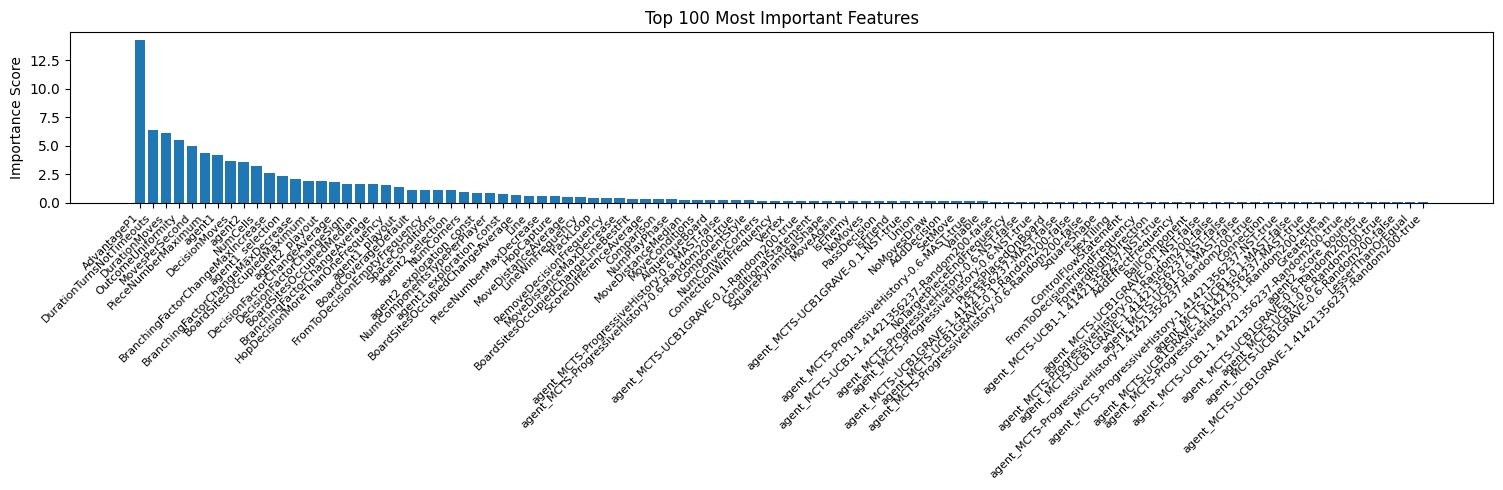

Fold 2 - RMSE: 0.4041219306048288
Fold 3


0:	learn: 0.6016464	test: 0.6073277	best: 0.6073277 (0)	total: 73.8ms	remaining: 3m 41s


50:	learn: 0.3889714	test: 0.4823601	best: 0.4823601 (50)	total: 3.97s	remaining: 3m 49s


100:	learn: 0.3476320	test: 0.4583453	best: 0.4583453 (100)	total: 8.26s	remaining: 3m 57s


150:	learn: 0.3253962	test: 0.4471270	best: 0.4471270 (150)	total: 12.4s	remaining: 3m 54s


200:	learn: 0.3105140	test: 0.4418626	best: 0.4418626 (200)	total: 16.5s	remaining: 3m 50s


250:	learn: 0.2995760	test: 0.4388724	best: 0.4388647 (249)	total: 20.6s	remaining: 3m 45s


300:	learn: 0.2907598	test: 0.4365973	best: 0.4365973 (300)	total: 24.7s	remaining: 3m 41s


350:	learn: 0.2828634	test: 0.4348710	best: 0.4348710 (350)	total: 28.9s	remaining: 3m 37s


400:	learn: 0.2764845	test: 0.4340919	best: 0.4340435 (399)	total: 33s	remaining: 3m 33s


450:	learn: 0.2705606	test: 0.4328969	best: 0.4328969 (450)	total: 37.1s	remaining: 3m 29s


500:	learn: 0.2652457	test: 0.4320242	best: 0.4320242 (500)	total: 41.3s	remaining: 3m 25s


550:	learn: 0.2602646	test: 0.4313305	best: 0.4313305 (550)	total: 45.4s	remaining: 3m 21s


600:	learn: 0.2560295	test: 0.4304049	best: 0.4303929 (598)	total: 49.5s	remaining: 3m 17s


650:	learn: 0.2521447	test: 0.4297755	best: 0.4297755 (650)	total: 53.7s	remaining: 3m 13s


700:	learn: 0.2482730	test: 0.4292535	best: 0.4292330 (699)	total: 57.8s	remaining: 3m 9s


750:	learn: 0.2448351	test: 0.4290876	best: 0.4290721 (735)	total: 1m 1s	remaining: 3m 5s


800:	learn: 0.2414856	test: 0.4286358	best: 0.4286181 (797)	total: 1m 6s	remaining: 3m 1s


850:	learn: 0.2380050	test: 0.4284545	best: 0.4284545 (850)	total: 1m 10s	remaining: 2m 57s


900:	learn: 0.2352347	test: 0.4282312	best: 0.4282295 (896)	total: 1m 14s	remaining: 2m 53s


950:	learn: 0.2324922	test: 0.4280022	best: 0.4279807 (935)	total: 1m 18s	remaining: 2m 49s


1000:	learn: 0.2300543	test: 0.4279562	best: 0.4279144 (965)	total: 1m 22s	remaining: 2m 44s


1050:	learn: 0.2277630	test: 0.4278008	best: 0.4277643 (1041)	total: 1m 26s	remaining: 2m 40s


1100:	learn: 0.2255212	test: 0.4275437	best: 0.4275380 (1098)	total: 1m 30s	remaining: 2m 36s


1150:	learn: 0.2230665	test: 0.4273362	best: 0.4273243 (1146)	total: 1m 35s	remaining: 2m 32s


1200:	learn: 0.2209313	test: 0.4271322	best: 0.4271212 (1193)	total: 1m 39s	remaining: 2m 28s


1250:	learn: 0.2188057	test: 0.4271959	best: 0.4271051 (1225)	total: 1m 43s	remaining: 2m 24s


1300:	learn: 0.2164532	test: 0.4270185	best: 0.4270139 (1299)	total: 1m 47s	remaining: 2m 20s


1350:	learn: 0.2144858	test: 0.4269671	best: 0.4269671 (1350)	total: 1m 51s	remaining: 2m 15s


1400:	learn: 0.2125298	test: 0.4268254	best: 0.4268254 (1400)	total: 1m 55s	remaining: 2m 11s


1450:	learn: 0.2106969	test: 0.4267318	best: 0.4267318 (1450)	total: 1m 59s	remaining: 2m 7s


1500:	learn: 0.2088208	test: 0.4266638	best: 0.4266575 (1497)	total: 2m 3s	remaining: 2m 3s


1550:	learn: 0.2071617	test: 0.4266415	best: 0.4266178 (1535)	total: 2m 7s	remaining: 1m 59s


1600:	learn: 0.2055538	test: 0.4266177	best: 0.4266046 (1588)	total: 2m 11s	remaining: 1m 55s


1650:	learn: 0.2037861	test: 0.4265741	best: 0.4265670 (1644)	total: 2m 15s	remaining: 1m 50s


1700:	learn: 0.2020016	test: 0.4265148	best: 0.4264918 (1662)	total: 2m 19s	remaining: 1m 46s


1750:	learn: 0.2004037	test: 0.4264027	best: 0.4263959 (1734)	total: 2m 23s	remaining: 1m 42s


1800:	learn: 0.1989223	test: 0.4263341	best: 0.4263167 (1757)	total: 2m 27s	remaining: 1m 38s


1850:	learn: 0.1972380	test: 0.4261888	best: 0.4261796 (1841)	total: 2m 31s	remaining: 1m 34s


1900:	learn: 0.1957396	test: 0.4260154	best: 0.4260154 (1900)	total: 2m 36s	remaining: 1m 30s


1950:	learn: 0.1942518	test: 0.4259241	best: 0.4259241 (1950)	total: 2m 40s	remaining: 1m 26s


2000:	learn: 0.1929564	test: 0.4258911	best: 0.4258743 (1998)	total: 2m 44s	remaining: 1m 21s


2050:	learn: 0.1915083	test: 0.4259003	best: 0.4258743 (1998)	total: 2m 48s	remaining: 1m 17s


2100:	learn: 0.1900250	test: 0.4258106	best: 0.4258106 (2100)	total: 2m 52s	remaining: 1m 13s


2150:	learn: 0.1888065	test: 0.4257366	best: 0.4257366 (2150)	total: 2m 56s	remaining: 1m 9s


2200:	learn: 0.1875440	test: 0.4257900	best: 0.4257366 (2150)	total: 3m	remaining: 1m 5s


2250:	learn: 0.1862923	test: 0.4257005	best: 0.4256842 (2237)	total: 3m 4s	remaining: 1m 1s


2300:	learn: 0.1849946	test: 0.4256953	best: 0.4256842 (2237)	total: 3m 9s	remaining: 57.5s


2350:	learn: 0.1837920	test: 0.4257027	best: 0.4256634 (2326)	total: 3m 13s	remaining: 53.4s


2400:	learn: 0.1825492	test: 0.4256652	best: 0.4256634 (2326)	total: 3m 17s	remaining: 49.2s


2450:	learn: 0.1814108	test: 0.4256299	best: 0.4256177 (2440)	total: 3m 21s	remaining: 45.1s


2500:	learn: 0.1802064	test: 0.4255634	best: 0.4255602 (2496)	total: 3m 25s	remaining: 41s


2550:	learn: 0.1790861	test: 0.4255622	best: 0.4255435 (2514)	total: 3m 29s	remaining: 36.9s


2600:	learn: 0.1779295	test: 0.4255020	best: 0.4255007 (2591)	total: 3m 33s	remaining: 32.8s


2650:	learn: 0.1767893	test: 0.4254538	best: 0.4254485 (2637)	total: 3m 37s	remaining: 28.7s


2700:	learn: 0.1756546	test: 0.4253735	best: 0.4253735 (2700)	total: 3m 41s	remaining: 24.5s


2750:	learn: 0.1745117	test: 0.4253885	best: 0.4253595 (2706)	total: 3m 45s	remaining: 20.4s


2800:	learn: 0.1733105	test: 0.4253433	best: 0.4253370 (2799)	total: 3m 49s	remaining: 16.3s


2850:	learn: 0.1722295	test: 0.4252766	best: 0.4252697 (2842)	total: 3m 54s	remaining: 12.2s


2900:	learn: 0.1711488	test: 0.4252693	best: 0.4252492 (2857)	total: 3m 58s	remaining: 8.13s


2950:	learn: 0.1700913	test: 0.4252387	best: 0.4252172 (2942)	total: 4m 2s	remaining: 4.02s


2999:	learn: 0.1691292	test: 0.4252237	best: 0.4252059 (2974)	total: 4m 6s	remaining: 0us

bestTest = 0.4252059189
bestIteration = 2974

Shrink model to first 2975 iterations.


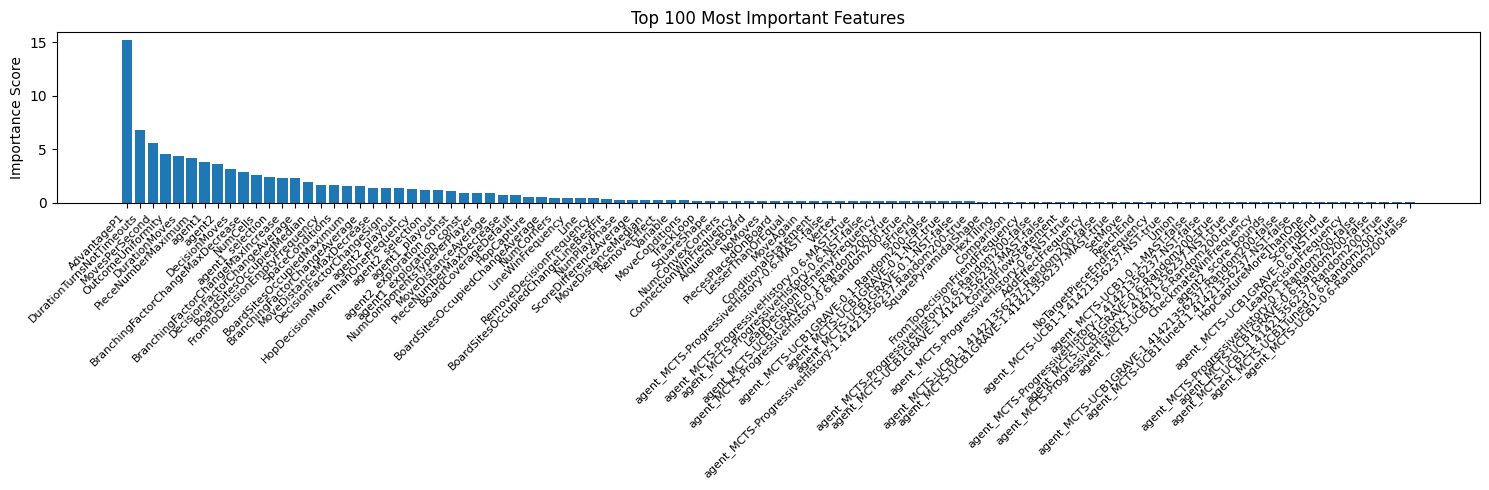

Fold 3 - RMSE: 0.42458130055493604
Fold 4


0:	learn: 0.6045008	test: 0.5958019	best: 0.5958019 (0)	total: 73.9ms	remaining: 3m 41s


50:	learn: 0.3972471	test: 0.4795853	best: 0.4795853 (50)	total: 3.82s	remaining: 3m 40s


100:	learn: 0.3586891	test: 0.4604044	best: 0.4604044 (100)	total: 7.83s	remaining: 3m 44s


150:	learn: 0.3343983	test: 0.4521687	best: 0.4521687 (150)	total: 11.8s	remaining: 3m 42s


200:	learn: 0.3184223	test: 0.4472778	best: 0.4472778 (200)	total: 15.8s	remaining: 3m 39s


250:	learn: 0.3063857	test: 0.4453809	best: 0.4452553 (247)	total: 19.8s	remaining: 3m 36s


300:	learn: 0.2966585	test: 0.4432064	best: 0.4432064 (300)	total: 23.8s	remaining: 3m 33s


350:	learn: 0.2883502	test: 0.4420301	best: 0.4420095 (349)	total: 28s	remaining: 3m 31s


400:	learn: 0.2815688	test: 0.4415117	best: 0.4414854 (394)	total: 32.1s	remaining: 3m 28s


450:	learn: 0.2753084	test: 0.4408869	best: 0.4408472 (447)	total: 36.3s	remaining: 3m 24s


500:	learn: 0.2704932	test: 0.4400938	best: 0.4400938 (500)	total: 40.5s	remaining: 3m 22s


550:	learn: 0.2654260	test: 0.4393124	best: 0.4393124 (550)	total: 44.5s	remaining: 3m 17s


600:	learn: 0.2605574	test: 0.4385837	best: 0.4385837 (600)	total: 48.6s	remaining: 3m 14s


650:	learn: 0.2565079	test: 0.4379924	best: 0.4379613 (643)	total: 52.9s	remaining: 3m 10s


700:	learn: 0.2526331	test: 0.4374585	best: 0.4374585 (700)	total: 56.9s	remaining: 3m 6s


750:	learn: 0.2493394	test: 0.4372246	best: 0.4372244 (745)	total: 1m 1s	remaining: 3m 2s


800:	learn: 0.2460485	test: 0.4370596	best: 0.4370434 (772)	total: 1m 5s	remaining: 2m 58s


850:	learn: 0.2427233	test: 0.4366385	best: 0.4366385 (850)	total: 1m 9s	remaining: 2m 54s


900:	learn: 0.2395487	test: 0.4364191	best: 0.4363711 (898)	total: 1m 13s	remaining: 2m 50s


950:	learn: 0.2368114	test: 0.4362594	best: 0.4361930 (939)	total: 1m 17s	remaining: 2m 47s


1000:	learn: 0.2340806	test: 0.4362711	best: 0.4361930 (939)	total: 1m 21s	remaining: 2m 43s


1050:	learn: 0.2317354	test: 0.4362457	best: 0.4361930 (939)	total: 1m 25s	remaining: 2m 38s


1100:	learn: 0.2293195	test: 0.4360521	best: 0.4360521 (1100)	total: 1m 29s	remaining: 2m 34s


1150:	learn: 0.2269161	test: 0.4361351	best: 0.4360521 (1100)	total: 1m 33s	remaining: 2m 30s


1200:	learn: 0.2246934	test: 0.4358104	best: 0.4358104 (1200)	total: 1m 37s	remaining: 2m 26s


1250:	learn: 0.2226127	test: 0.4357830	best: 0.4357460 (1240)	total: 1m 42s	remaining: 2m 22s


1300:	learn: 0.2205767	test: 0.4356719	best: 0.4356485 (1294)	total: 1m 46s	remaining: 2m 18s


1350:	learn: 0.2185007	test: 0.4355024	best: 0.4354535 (1336)	total: 1m 50s	remaining: 2m 14s


1400:	learn: 0.2164669	test: 0.4353710	best: 0.4353556 (1393)	total: 1m 54s	remaining: 2m 10s


1450:	learn: 0.2146690	test: 0.4352513	best: 0.4352427 (1449)	total: 1m 58s	remaining: 2m 6s


1500:	learn: 0.2128265	test: 0.4350826	best: 0.4350768 (1499)	total: 2m 2s	remaining: 2m 2s


1550:	learn: 0.2111186	test: 0.4350179	best: 0.4349867 (1539)	total: 2m 6s	remaining: 1m 58s


1600:	learn: 0.2092435	test: 0.4350645	best: 0.4349867 (1539)	total: 2m 10s	remaining: 1m 54s


1650:	learn: 0.2075839	test: 0.4351337	best: 0.4349867 (1539)	total: 2m 15s	remaining: 1m 50s


1700:	learn: 0.2059161	test: 0.4351792	best: 0.4349867 (1539)	total: 2m 19s	remaining: 1m 46s


1750:	learn: 0.2043135	test: 0.4351773	best: 0.4349867 (1539)	total: 2m 23s	remaining: 1m 42s


1800:	learn: 0.2026450	test: 0.4351393	best: 0.4349867 (1539)	total: 2m 27s	remaining: 1m 38s


1850:	learn: 0.2011632	test: 0.4351301	best: 0.4349867 (1539)	total: 2m 31s	remaining: 1m 34s


1900:	learn: 0.1997041	test: 0.4350664	best: 0.4349867 (1539)	total: 2m 36s	remaining: 1m 30s


1950:	learn: 0.1981089	test: 0.4350131	best: 0.4349867 (1539)	total: 2m 40s	remaining: 1m 26s


2000:	learn: 0.1967581	test: 0.4349434	best: 0.4349103 (1992)	total: 2m 44s	remaining: 1m 22s


2050:	learn: 0.1953140	test: 0.4350989	best: 0.4349103 (1992)	total: 2m 48s	remaining: 1m 17s


2100:	learn: 0.1938894	test: 0.4350718	best: 0.4349103 (1992)	total: 2m 52s	remaining: 1m 13s


2150:	learn: 0.1926374	test: 0.4351168	best: 0.4349103 (1992)	total: 2m 56s	remaining: 1m 9s


2200:	learn: 0.1912267	test: 0.4350464	best: 0.4349103 (1992)	total: 3m 1s	remaining: 1m 5s


2250:	learn: 0.1899554	test: 0.4350770	best: 0.4349103 (1992)	total: 3m 5s	remaining: 1m 1s


2300:	learn: 0.1887031	test: 0.4350897	best: 0.4349103 (1992)	total: 3m 9s	remaining: 57.6s


2350:	learn: 0.1872743	test: 0.4350520	best: 0.4349103 (1992)	total: 3m 13s	remaining: 53.5s


2400:	learn: 0.1860497	test: 0.4350294	best: 0.4349103 (1992)	total: 3m 18s	remaining: 49.5s


2450:	learn: 0.1848519	test: 0.4350167	best: 0.4349103 (1992)	total: 3m 22s	remaining: 45.4s


2500:	learn: 0.1836409	test: 0.4350643	best: 0.4349103 (1992)	total: 3m 26s	remaining: 41.2s


2550:	learn: 0.1824443	test: 0.4350032	best: 0.4349103 (1992)	total: 3m 30s	remaining: 37.1s


2600:	learn: 0.1812824	test: 0.4349946	best: 0.4349103 (1992)	total: 3m 35s	remaining: 33s


2650:	learn: 0.1800782	test: 0.4348610	best: 0.4348601 (2649)	total: 3m 39s	remaining: 28.9s


2700:	learn: 0.1788737	test: 0.4349200	best: 0.4348565 (2661)	total: 3m 43s	remaining: 24.8s


2750:	learn: 0.1777706	test: 0.4349112	best: 0.4348565 (2661)	total: 3m 47s	remaining: 20.6s


2800:	learn: 0.1766445	test: 0.4349612	best: 0.4348565 (2661)	total: 3m 52s	remaining: 16.5s


2850:	learn: 0.1755095	test: 0.4349162	best: 0.4348565 (2661)	total: 3m 56s	remaining: 12.3s


2900:	learn: 0.1743502	test: 0.4348516	best: 0.4348476 (2881)	total: 4m	remaining: 8.21s


2950:	learn: 0.1732427	test: 0.4348099	best: 0.4347933 (2934)	total: 4m 4s	remaining: 4.06s


2999:	learn: 0.1721473	test: 0.4348207	best: 0.4347933 (2934)	total: 4m 8s	remaining: 0us

bestTest = 0.4347933219
bestIteration = 2934

Shrink model to first 2935 iterations.


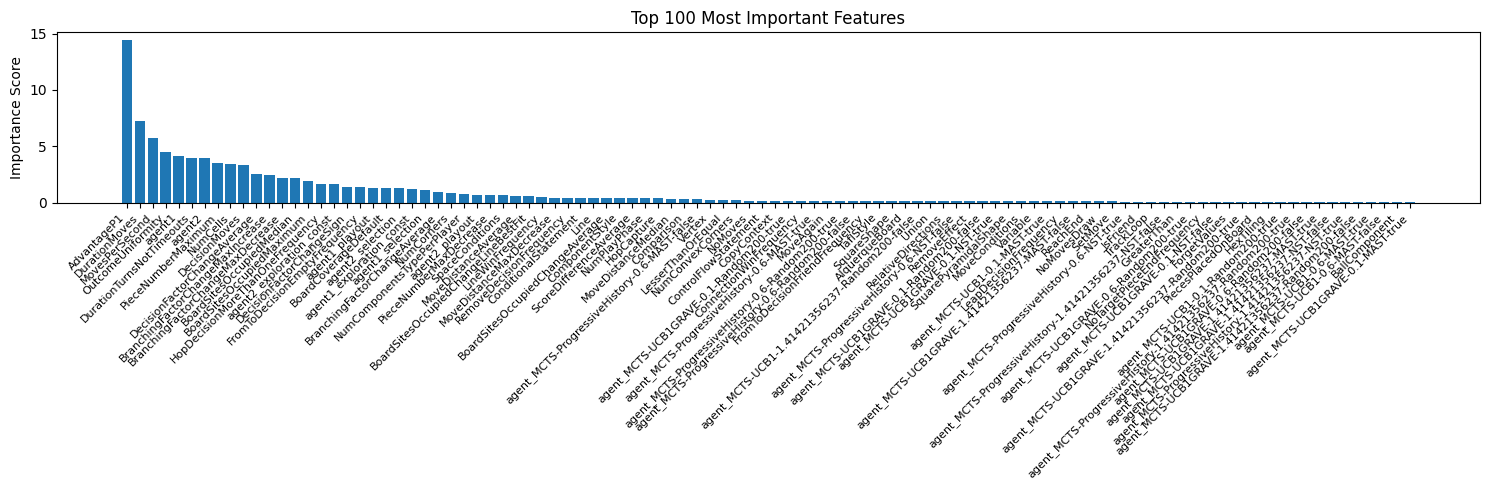

Fold 4 - RMSE: 0.4342876701617734
Fold 5


0:	learn: 0.6067276	test: 0.5834392	best: 0.5834392 (0)	total: 60.9ms	remaining: 3m 2s


50:	learn: 0.3925698	test: 0.4785332	best: 0.4785332 (50)	total: 3.86s	remaining: 3m 43s


100:	learn: 0.3542242	test: 0.4552580	best: 0.4552580 (100)	total: 8.12s	remaining: 3m 53s


150:	learn: 0.3313419	test: 0.4479370	best: 0.4479370 (150)	total: 12.2s	remaining: 3m 50s


200:	learn: 0.3153314	test: 0.4427213	best: 0.4427213 (200)	total: 16.5s	remaining: 3m 49s


250:	learn: 0.3043302	test: 0.4401742	best: 0.4401742 (250)	total: 20.6s	remaining: 3m 46s


300:	learn: 0.2950432	test: 0.4386092	best: 0.4386092 (300)	total: 24.8s	remaining: 3m 42s


350:	learn: 0.2866835	test: 0.4365286	best: 0.4365286 (350)	total: 29.1s	remaining: 3m 39s


400:	learn: 0.2796473	test: 0.4355955	best: 0.4354978 (395)	total: 33.4s	remaining: 3m 36s


450:	learn: 0.2731107	test: 0.4344141	best: 0.4344104 (449)	total: 37.8s	remaining: 3m 33s


500:	learn: 0.2672087	test: 0.4335209	best: 0.4334742 (488)	total: 42.2s	remaining: 3m 30s


550:	learn: 0.2625766	test: 0.4326512	best: 0.4326231 (544)	total: 46.6s	remaining: 3m 27s


600:	learn: 0.2579859	test: 0.4318924	best: 0.4318685 (598)	total: 51s	remaining: 3m 23s


650:	learn: 0.2540126	test: 0.4313109	best: 0.4313109 (650)	total: 55.4s	remaining: 3m 19s


700:	learn: 0.2505038	test: 0.4308782	best: 0.4308315 (694)	total: 59.7s	remaining: 3m 15s


750:	learn: 0.2470153	test: 0.4304425	best: 0.4304248 (740)	total: 1m 4s	remaining: 3m 12s


800:	learn: 0.2439595	test: 0.4303823	best: 0.4303017 (795)	total: 1m 8s	remaining: 3m 8s


850:	learn: 0.2406927	test: 0.4303289	best: 0.4303017 (795)	total: 1m 12s	remaining: 3m 4s


900:	learn: 0.2376591	test: 0.4300141	best: 0.4300141 (900)	total: 1m 17s	remaining: 3m


950:	learn: 0.2349811	test: 0.4297709	best: 0.4297251 (942)	total: 1m 21s	remaining: 2m 56s


1000:	learn: 0.2323960	test: 0.4294431	best: 0.4294431 (1000)	total: 1m 26s	remaining: 2m 51s


1050:	learn: 0.2299687	test: 0.4292608	best: 0.4292391 (1047)	total: 1m 30s	remaining: 2m 47s


1100:	learn: 0.2274555	test: 0.4291993	best: 0.4291022 (1091)	total: 1m 34s	remaining: 2m 43s


1150:	learn: 0.2251733	test: 0.4290850	best: 0.4290812 (1145)	total: 1m 39s	remaining: 2m 39s


1200:	learn: 0.2229876	test: 0.4288675	best: 0.4288525 (1197)	total: 1m 43s	remaining: 2m 35s


1250:	learn: 0.2207755	test: 0.4288463	best: 0.4287755 (1240)	total: 1m 48s	remaining: 2m 31s


1300:	learn: 0.2185433	test: 0.4287400	best: 0.4286787 (1289)	total: 1m 52s	remaining: 2m 26s


1350:	learn: 0.2164496	test: 0.4285894	best: 0.4285867 (1348)	total: 1m 56s	remaining: 2m 22s


1400:	learn: 0.2145107	test: 0.4286429	best: 0.4285222 (1379)	total: 2m 1s	remaining: 2m 18s


1450:	learn: 0.2127761	test: 0.4286144	best: 0.4285222 (1379)	total: 2m 5s	remaining: 2m 13s


1500:	learn: 0.2108863	test: 0.4285937	best: 0.4285222 (1379)	total: 2m 9s	remaining: 2m 9s


1550:	learn: 0.2091087	test: 0.4284656	best: 0.4284644 (1549)	total: 2m 14s	remaining: 2m 5s


1600:	learn: 0.2074415	test: 0.4284258	best: 0.4284001 (1577)	total: 2m 18s	remaining: 2m


1650:	learn: 0.2056077	test: 0.4283823	best: 0.4283503 (1624)	total: 2m 22s	remaining: 1m 56s


1700:	learn: 0.2039404	test: 0.4283053	best: 0.4282901 (1696)	total: 2m 26s	remaining: 1m 52s


1750:	learn: 0.2023703	test: 0.4282928	best: 0.4282901 (1705)	total: 2m 31s	remaining: 1m 47s


1800:	learn: 0.2009327	test: 0.4282350	best: 0.4282282 (1776)	total: 2m 35s	remaining: 1m 43s


1850:	learn: 0.1991586	test: 0.4282994	best: 0.4282072 (1807)	total: 2m 39s	remaining: 1m 39s


1900:	learn: 0.1976754	test: 0.4281979	best: 0.4281937 (1868)	total: 2m 44s	remaining: 1m 34s


1950:	learn: 0.1961814	test: 0.4281266	best: 0.4281016 (1939)	total: 2m 48s	remaining: 1m 30s


2000:	learn: 0.1945951	test: 0.4281095	best: 0.4281016 (1939)	total: 2m 53s	remaining: 1m 26s


2050:	learn: 0.1931803	test: 0.4280842	best: 0.4280448 (2031)	total: 2m 57s	remaining: 1m 22s


2100:	learn: 0.1918075	test: 0.4280504	best: 0.4280122 (2093)	total: 3m 1s	remaining: 1m 17s


2150:	learn: 0.1903832	test: 0.4279871	best: 0.4279861 (2149)	total: 3m 5s	remaining: 1m 13s


2200:	learn: 0.1889151	test: 0.4279743	best: 0.4279250 (2192)	total: 3m 10s	remaining: 1m 9s


2250:	learn: 0.1875015	test: 0.4279141	best: 0.4279077 (2246)	total: 3m 14s	remaining: 1m 4s


2300:	learn: 0.1860700	test: 0.4278888	best: 0.4278589 (2287)	total: 3m 18s	remaining: 1m


2350:	learn: 0.1847927	test: 0.4278425	best: 0.4278035 (2324)	total: 3m 23s	remaining: 56.1s


2400:	learn: 0.1834444	test: 0.4277548	best: 0.4277279 (2394)	total: 3m 27s	remaining: 51.8s


2450:	learn: 0.1822180	test: 0.4277133	best: 0.4277133 (2450)	total: 3m 31s	remaining: 47.5s


2500:	learn: 0.1810284	test: 0.4276883	best: 0.4276490 (2475)	total: 3m 36s	remaining: 43.2s


2550:	learn: 0.1797870	test: 0.4276481	best: 0.4276394 (2542)	total: 3m 40s	remaining: 38.8s


2600:	learn: 0.1786365	test: 0.4276401	best: 0.4276243 (2572)	total: 3m 44s	remaining: 34.5s


2650:	learn: 0.1775170	test: 0.4276493	best: 0.4276217 (2619)	total: 3m 49s	remaining: 30.2s


2700:	learn: 0.1762961	test: 0.4275795	best: 0.4275795 (2700)	total: 3m 53s	remaining: 25.9s


2750:	learn: 0.1751445	test: 0.4275808	best: 0.4275587 (2712)	total: 3m 57s	remaining: 21.5s


2800:	learn: 0.1741141	test: 0.4275415	best: 0.4275415 (2800)	total: 4m 2s	remaining: 17.2s


2850:	learn: 0.1729276	test: 0.4274169	best: 0.4274131 (2849)	total: 4m 6s	remaining: 12.9s


2900:	learn: 0.1718144	test: 0.4273404	best: 0.4273404 (2900)	total: 4m 10s	remaining: 8.55s


2950:	learn: 0.1707701	test: 0.4273982	best: 0.4273404 (2900)	total: 4m 14s	remaining: 4.23s


2999:	learn: 0.1697784	test: 0.4274052	best: 0.4273404 (2900)	total: 4m 19s	remaining: 0us

bestTest = 0.4273403618
bestIteration = 2900

Shrink model to first 2901 iterations.


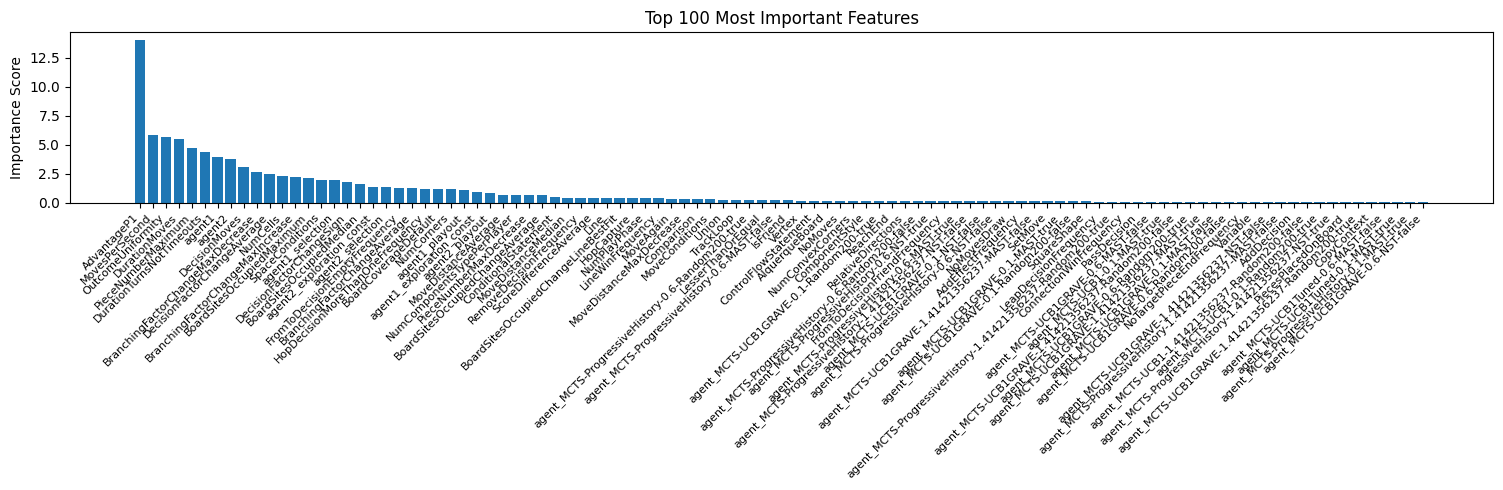

Fold 5 - RMSE: 0.4265348494651625
List of oof scores: [0.4153090352637169, 0.4041219306048288, 0.42458130055493604, 0.4342876701617734, 0.4265348494651625]
Average oof score: 0.4209669572100835


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_catboost_{fs_type}_cv2.parquet', index=False)

Fold 1


0:	learn: 0.6090031	test: 0.5696042	best: 0.5696042 (0)	total: 60.5ms	remaining: 3m 1s


50:	learn: 0.3945018	test: 0.4679119	best: 0.4679119 (50)	total: 3.91s	remaining: 3m 46s


100:	learn: 0.3520516	test: 0.4504377	best: 0.4504377 (100)	total: 8.04s	remaining: 3m 50s


150:	learn: 0.3295068	test: 0.4442929	best: 0.4442929 (150)	total: 12.2s	remaining: 3m 50s


200:	learn: 0.3130276	test: 0.4409011	best: 0.4409011 (200)	total: 16.3s	remaining: 3m 47s


250:	learn: 0.3017516	test: 0.4379517	best: 0.4379517 (250)	total: 20.6s	remaining: 3m 45s


300:	learn: 0.2923654	test: 0.4368744	best: 0.4368292 (299)	total: 24.8s	remaining: 3m 42s


350:	learn: 0.2842632	test: 0.4353006	best: 0.4353006 (350)	total: 29.1s	remaining: 3m 39s


400:	learn: 0.2765077	test: 0.4340748	best: 0.4340548 (395)	total: 33.4s	remaining: 3m 36s


450:	learn: 0.2699811	test: 0.4330178	best: 0.4329515 (445)	total: 37.7s	remaining: 3m 32s


500:	learn: 0.2641758	test: 0.4324906	best: 0.4324906 (500)	total: 42.1s	remaining: 3m 30s


550:	learn: 0.2594476	test: 0.4315242	best: 0.4314930 (549)	total: 46.5s	remaining: 3m 26s


600:	learn: 0.2551364	test: 0.4310738	best: 0.4310738 (600)	total: 50.7s	remaining: 3m 22s


650:	learn: 0.2513179	test: 0.4306090	best: 0.4306090 (650)	total: 55s	remaining: 3m 18s


700:	learn: 0.2477795	test: 0.4305539	best: 0.4305054 (693)	total: 59.5s	remaining: 3m 15s


750:	learn: 0.2442342	test: 0.4301107	best: 0.4301107 (750)	total: 1m 3s	remaining: 3m 11s


800:	learn: 0.2408298	test: 0.4300675	best: 0.4300046 (792)	total: 1m 8s	remaining: 3m 7s


850:	learn: 0.2379023	test: 0.4299232	best: 0.4299047 (849)	total: 1m 12s	remaining: 3m 3s


900:	learn: 0.2353464	test: 0.4297844	best: 0.4297703 (895)	total: 1m 17s	remaining: 3m


950:	learn: 0.2326996	test: 0.4296368	best: 0.4296267 (947)	total: 1m 21s	remaining: 2m 56s


1000:	learn: 0.2299236	test: 0.4293144	best: 0.4293144 (1000)	total: 1m 26s	remaining: 2m 51s


1050:	learn: 0.2273857	test: 0.4291968	best: 0.4291968 (1050)	total: 1m 30s	remaining: 2m 47s


1100:	learn: 0.2247515	test: 0.4289726	best: 0.4289631 (1099)	total: 1m 34s	remaining: 2m 43s


1150:	learn: 0.2225302	test: 0.4289653	best: 0.4288999 (1109)	total: 1m 38s	remaining: 2m 38s


1200:	learn: 0.2205219	test: 0.4287956	best: 0.4287834 (1198)	total: 1m 43s	remaining: 2m 34s


1250:	learn: 0.2184923	test: 0.4286521	best: 0.4286521 (1250)	total: 1m 47s	remaining: 2m 30s


1300:	learn: 0.2164360	test: 0.4284567	best: 0.4284134 (1283)	total: 1m 52s	remaining: 2m 26s


1350:	learn: 0.2145049	test: 0.4285297	best: 0.4284134 (1283)	total: 1m 56s	remaining: 2m 22s


1400:	learn: 0.2126067	test: 0.4285628	best: 0.4284134 (1283)	total: 2m	remaining: 2m 18s


1450:	learn: 0.2106593	test: 0.4286310	best: 0.4284134 (1283)	total: 2m 5s	remaining: 2m 13s


1500:	learn: 0.2089322	test: 0.4286253	best: 0.4284134 (1283)	total: 2m 9s	remaining: 2m 9s


1550:	learn: 0.2071141	test: 0.4286072	best: 0.4284134 (1283)	total: 2m 13s	remaining: 2m 5s


1600:	learn: 0.2053375	test: 0.4286361	best: 0.4284134 (1283)	total: 2m 18s	remaining: 2m


1650:	learn: 0.2037225	test: 0.4286882	best: 0.4284134 (1283)	total: 2m 22s	remaining: 1m 56s


1700:	learn: 0.2021799	test: 0.4287302	best: 0.4284134 (1283)	total: 2m 27s	remaining: 1m 52s


1750:	learn: 0.2006096	test: 0.4286771	best: 0.4284134 (1283)	total: 2m 31s	remaining: 1m 48s


1800:	learn: 0.1990173	test: 0.4286657	best: 0.4284134 (1283)	total: 2m 35s	remaining: 1m 43s


1850:	learn: 0.1975375	test: 0.4286432	best: 0.4284134 (1283)	total: 2m 40s	remaining: 1m 39s


1900:	learn: 0.1961265	test: 0.4285826	best: 0.4284134 (1283)	total: 2m 44s	remaining: 1m 35s


1950:	learn: 0.1947590	test: 0.4284683	best: 0.4284134 (1283)	total: 2m 48s	remaining: 1m 30s


2000:	learn: 0.1934381	test: 0.4284470	best: 0.4283781 (1973)	total: 2m 53s	remaining: 1m 26s


2050:	learn: 0.1920212	test: 0.4283932	best: 0.4283781 (1973)	total: 2m 57s	remaining: 1m 22s


2100:	learn: 0.1906101	test: 0.4283873	best: 0.4283616 (2070)	total: 3m 1s	remaining: 1m 17s


2150:	learn: 0.1891839	test: 0.4284070	best: 0.4283496 (2117)	total: 3m 5s	remaining: 1m 13s


2200:	learn: 0.1879502	test: 0.4283884	best: 0.4283496 (2117)	total: 3m 10s	remaining: 1m 9s


2250:	learn: 0.1866986	test: 0.4283655	best: 0.4283496 (2117)	total: 3m 14s	remaining: 1m 4s


2300:	learn: 0.1854173	test: 0.4283890	best: 0.4283282 (2258)	total: 3m 18s	remaining: 1m


2350:	learn: 0.1841419	test: 0.4283858	best: 0.4283272 (2334)	total: 3m 23s	remaining: 56.1s


2400:	learn: 0.1829332	test: 0.4284234	best: 0.4283272 (2334)	total: 3m 27s	remaining: 51.8s


2450:	learn: 0.1817935	test: 0.4284473	best: 0.4283272 (2334)	total: 3m 31s	remaining: 47.5s


2500:	learn: 0.1806989	test: 0.4284631	best: 0.4283272 (2334)	total: 3m 36s	remaining: 43.1s


2550:	learn: 0.1795050	test: 0.4285060	best: 0.4283272 (2334)	total: 3m 40s	remaining: 38.8s


2600:	learn: 0.1784799	test: 0.4285030	best: 0.4283272 (2334)	total: 3m 44s	remaining: 34.5s


2650:	learn: 0.1772601	test: 0.4285595	best: 0.4283272 (2334)	total: 3m 49s	remaining: 30.2s


2700:	learn: 0.1760769	test: 0.4285532	best: 0.4283272 (2334)	total: 3m 53s	remaining: 25.9s


2750:	learn: 0.1749926	test: 0.4286008	best: 0.4283272 (2334)	total: 3m 58s	remaining: 21.5s


2800:	learn: 0.1739342	test: 0.4286462	best: 0.4283272 (2334)	total: 4m 2s	remaining: 17.2s


2850:	learn: 0.1728783	test: 0.4286769	best: 0.4283272 (2334)	total: 4m 6s	remaining: 12.9s


2900:	learn: 0.1718711	test: 0.4286913	best: 0.4283272 (2334)	total: 4m 11s	remaining: 8.57s


2950:	learn: 0.1709762	test: 0.4287831	best: 0.4283272 (2334)	total: 4m 15s	remaining: 4.24s


2999:	learn: 0.1699233	test: 0.4287274	best: 0.4283272 (2334)	total: 4m 19s	remaining: 0us

bestTest = 0.4283272181
bestIteration = 2334

Shrink model to first 2335 iterations.


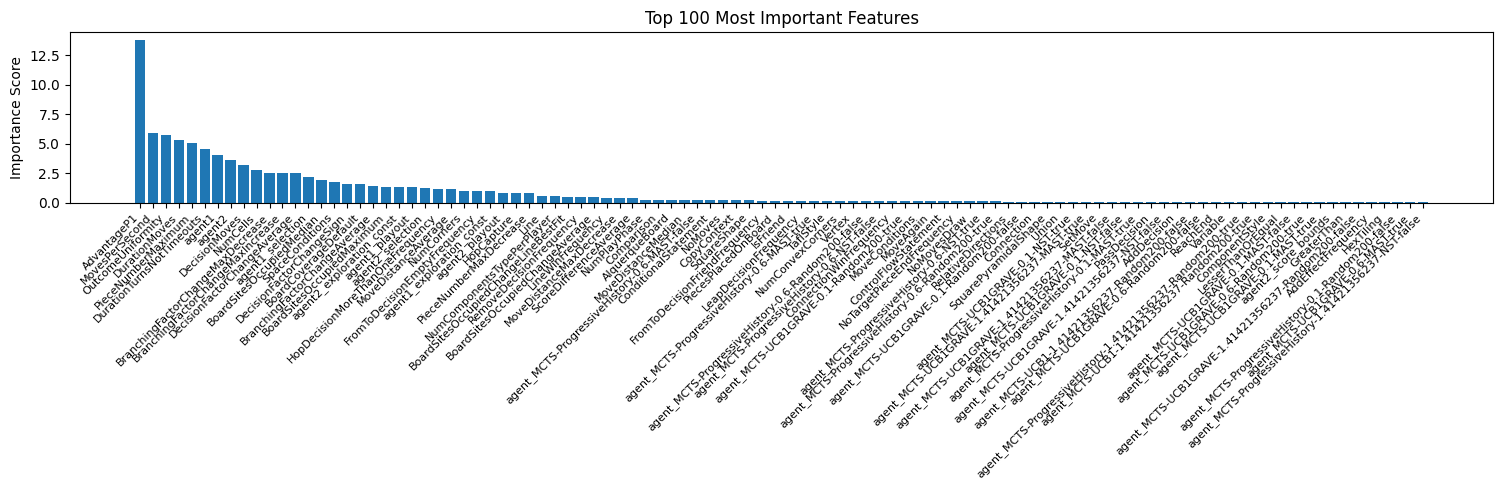

Fold 1 - RMSE: 0.42792657835597286
Fold 2


0:	learn: 0.6082640	test: 0.5671298	best: 0.5671298 (0)	total: 70.2ms	remaining: 3m 30s


50:	learn: 0.3958172	test: 0.4717178	best: 0.4717178 (50)	total: 4.11s	remaining: 3m 57s


100:	learn: 0.3538786	test: 0.4485239	best: 0.4485239 (100)	total: 8.38s	remaining: 4m


150:	learn: 0.3302322	test: 0.4382941	best: 0.4382941 (150)	total: 12.7s	remaining: 4m


200:	learn: 0.3144599	test: 0.4338547	best: 0.4337815 (198)	total: 17.1s	remaining: 3m 57s


250:	learn: 0.3038413	test: 0.4310500	best: 0.4310500 (250)	total: 21.4s	remaining: 3m 54s


300:	learn: 0.2947953	test: 0.4287710	best: 0.4287710 (300)	total: 25.7s	remaining: 3m 50s


350:	learn: 0.2865075	test: 0.4267063	best: 0.4266999 (344)	total: 30.1s	remaining: 3m 47s


400:	learn: 0.2797331	test: 0.4253182	best: 0.4253182 (400)	total: 34.5s	remaining: 3m 43s


450:	learn: 0.2737564	test: 0.4241020	best: 0.4240955 (449)	total: 38.9s	remaining: 3m 39s


500:	learn: 0.2679359	test: 0.4232190	best: 0.4232190 (500)	total: 43.3s	remaining: 3m 35s


550:	learn: 0.2634594	test: 0.4226147	best: 0.4226073 (547)	total: 47.8s	remaining: 3m 32s


600:	learn: 0.2591123	test: 0.4222146	best: 0.4222146 (600)	total: 52.2s	remaining: 3m 28s


650:	learn: 0.2545406	test: 0.4213493	best: 0.4213493 (650)	total: 56.6s	remaining: 3m 24s


700:	learn: 0.2503928	test: 0.4209062	best: 0.4208756 (692)	total: 1m	remaining: 3m 19s


750:	learn: 0.2469195	test: 0.4204619	best: 0.4204523 (749)	total: 1m 5s	remaining: 3m 15s


800:	learn: 0.2436588	test: 0.4200713	best: 0.4200640 (793)	total: 1m 9s	remaining: 3m 11s


850:	learn: 0.2408284	test: 0.4199745	best: 0.4199563 (848)	total: 1m 14s	remaining: 3m 7s


900:	learn: 0.2378357	test: 0.4195187	best: 0.4195187 (900)	total: 1m 18s	remaining: 3m 3s


950:	learn: 0.2351390	test: 0.4191566	best: 0.4191512 (943)	total: 1m 23s	remaining: 3m


1000:	learn: 0.2325355	test: 0.4188930	best: 0.4188930 (1000)	total: 1m 28s	remaining: 2m 56s


1050:	learn: 0.2300552	test: 0.4185498	best: 0.4185228 (1041)	total: 1m 33s	remaining: 2m 52s


1100:	learn: 0.2278016	test: 0.4183424	best: 0.4183408 (1098)	total: 1m 37s	remaining: 2m 48s


1150:	learn: 0.2254764	test: 0.4182653	best: 0.4181980 (1126)	total: 1m 42s	remaining: 2m 44s


1200:	learn: 0.2233077	test: 0.4180829	best: 0.4180658 (1199)	total: 1m 46s	remaining: 2m 40s


1250:	learn: 0.2211514	test: 0.4180035	best: 0.4179306 (1237)	total: 1m 51s	remaining: 2m 35s


1300:	learn: 0.2190677	test: 0.4178548	best: 0.4178463 (1298)	total: 1m 55s	remaining: 2m 31s


1350:	learn: 0.2170587	test: 0.4177099	best: 0.4176749 (1344)	total: 2m	remaining: 2m 26s


1400:	learn: 0.2151798	test: 0.4175738	best: 0.4175738 (1400)	total: 2m 4s	remaining: 2m 22s


1450:	learn: 0.2133798	test: 0.4175097	best: 0.4174837 (1433)	total: 2m 9s	remaining: 2m 17s


1500:	learn: 0.2115495	test: 0.4174048	best: 0.4174048 (1500)	total: 2m 13s	remaining: 2m 13s


1550:	learn: 0.2098175	test: 0.4171789	best: 0.4171617 (1546)	total: 2m 18s	remaining: 2m 8s


1600:	learn: 0.2079509	test: 0.4170064	best: 0.4170038 (1595)	total: 2m 22s	remaining: 2m 4s


1650:	learn: 0.2063013	test: 0.4169359	best: 0.4168969 (1644)	total: 2m 26s	remaining: 2m


1700:	learn: 0.2046677	test: 0.4168922	best: 0.4168518 (1664)	total: 2m 31s	remaining: 1m 55s


1750:	learn: 0.2030341	test: 0.4168710	best: 0.4168012 (1730)	total: 2m 35s	remaining: 1m 51s


1800:	learn: 0.2016224	test: 0.4166936	best: 0.4166936 (1800)	total: 2m 40s	remaining: 1m 46s


1850:	learn: 0.2001832	test: 0.4166863	best: 0.4166863 (1850)	total: 2m 44s	remaining: 1m 42s


1900:	learn: 0.1987409	test: 0.4166264	best: 0.4165805 (1888)	total: 2m 48s	remaining: 1m 37s


1950:	learn: 0.1974246	test: 0.4166123	best: 0.4165805 (1888)	total: 2m 53s	remaining: 1m 33s


2000:	learn: 0.1959563	test: 0.4165286	best: 0.4165208 (1996)	total: 2m 58s	remaining: 1m 28s


2050:	learn: 0.1946426	test: 0.4164084	best: 0.4164084 (2050)	total: 3m 2s	remaining: 1m 24s


2100:	learn: 0.1933323	test: 0.4164590	best: 0.4163979 (2053)	total: 3m 7s	remaining: 1m 20s


2150:	learn: 0.1919648	test: 0.4163527	best: 0.4163527 (2150)	total: 3m 11s	remaining: 1m 15s


2200:	learn: 0.1906942	test: 0.4162756	best: 0.4162756 (2200)	total: 3m 16s	remaining: 1m 11s


2250:	learn: 0.1893984	test: 0.4162863	best: 0.4162540 (2204)	total: 3m 20s	remaining: 1m 6s


2300:	learn: 0.1880652	test: 0.4163261	best: 0.4162460 (2269)	total: 3m 25s	remaining: 1m 2s


2350:	learn: 0.1867986	test: 0.4163001	best: 0.4162460 (2269)	total: 3m 29s	remaining: 58s


2400:	learn: 0.1855422	test: 0.4163276	best: 0.4162460 (2269)	total: 3m 34s	remaining: 53.5s


2450:	learn: 0.1843284	test: 0.4162744	best: 0.4162447 (2444)	total: 3m 39s	remaining: 49.1s


2500:	learn: 0.1831597	test: 0.4162739	best: 0.4162447 (2444)	total: 3m 43s	remaining: 44.6s


2550:	learn: 0.1819056	test: 0.4162044	best: 0.4161956 (2549)	total: 3m 47s	remaining: 40.1s


2600:	learn: 0.1806071	test: 0.4162310	best: 0.4161956 (2549)	total: 3m 52s	remaining: 35.6s


2650:	learn: 0.1794579	test: 0.4162389	best: 0.4161886 (2625)	total: 3m 56s	remaining: 31.2s


2700:	learn: 0.1781609	test: 0.4162476	best: 0.4161886 (2625)	total: 4m 1s	remaining: 26.7s


2750:	learn: 0.1770901	test: 0.4162722	best: 0.4161886 (2625)	total: 4m 5s	remaining: 22.2s


2800:	learn: 0.1759712	test: 0.4162305	best: 0.4161886 (2625)	total: 4m 10s	remaining: 17.8s


2850:	learn: 0.1749486	test: 0.4161828	best: 0.4161790 (2848)	total: 4m 14s	remaining: 13.3s


2900:	learn: 0.1737109	test: 0.4161726	best: 0.4161631 (2897)	total: 4m 19s	remaining: 8.84s


2950:	learn: 0.1726810	test: 0.4161066	best: 0.4161066 (2950)	total: 4m 23s	remaining: 4.38s


2999:	learn: 0.1717498	test: 0.4161173	best: 0.4160825 (2968)	total: 4m 28s	remaining: 0us

bestTest = 0.4160824592
bestIteration = 2968

Shrink model to first 2969 iterations.


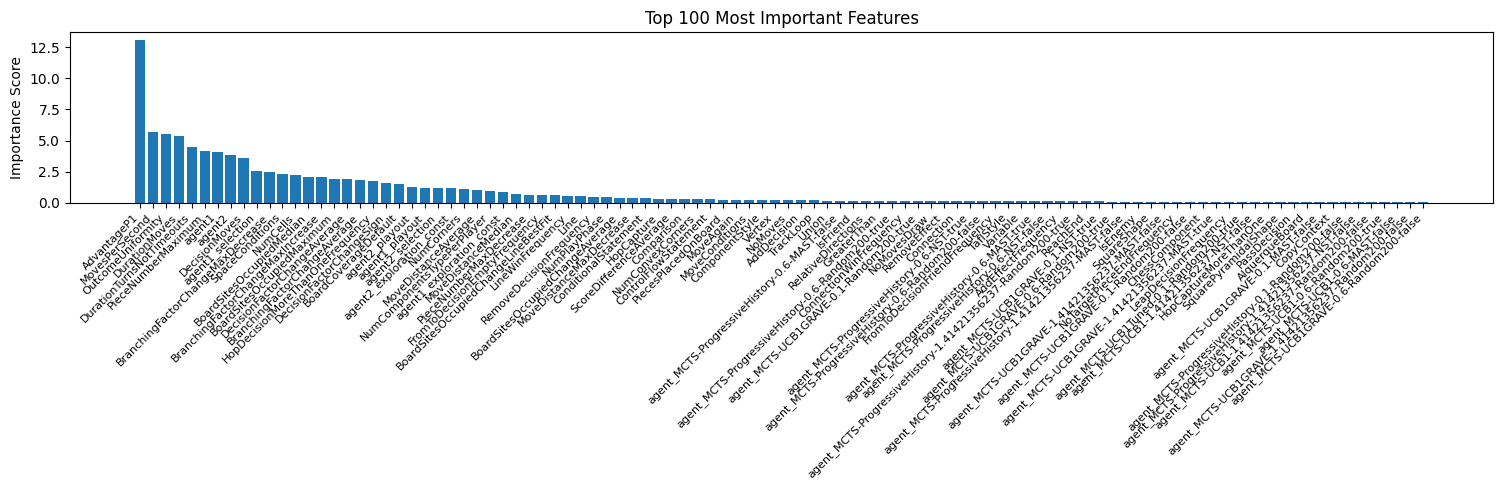

Fold 2 - RMSE: 0.41555135839155255
Fold 3


0:	learn: 0.6114645	test: 0.5669415	best: 0.5669415 (0)	total: 66.1ms	remaining: 3m 18s


50:	learn: 0.3963968	test: 0.4523927	best: 0.4523927 (50)	total: 3.89s	remaining: 3m 44s


100:	learn: 0.3540792	test: 0.4357541	best: 0.4357541 (100)	total: 8.09s	remaining: 3m 52s


150:	learn: 0.3282314	test: 0.4270737	best: 0.4270737 (150)	total: 12.2s	remaining: 3m 49s


200:	learn: 0.3135270	test: 0.4238558	best: 0.4238558 (200)	total: 16.4s	remaining: 3m 48s


250:	learn: 0.3018103	test: 0.4213978	best: 0.4213720 (248)	total: 20.6s	remaining: 3m 45s


300:	learn: 0.2928134	test: 0.4190200	best: 0.4189619 (295)	total: 24.7s	remaining: 3m 41s


350:	learn: 0.2844114	test: 0.4174432	best: 0.4174432 (350)	total: 28.8s	remaining: 3m 37s


400:	learn: 0.2776919	test: 0.4163008	best: 0.4163008 (400)	total: 33s	remaining: 3m 33s


450:	learn: 0.2718300	test: 0.4153674	best: 0.4153465 (447)	total: 37.3s	remaining: 3m 30s


500:	learn: 0.2664431	test: 0.4143981	best: 0.4143981 (500)	total: 41.5s	remaining: 3m 26s


550:	learn: 0.2612038	test: 0.4135644	best: 0.4135644 (550)	total: 45.8s	remaining: 3m 23s


600:	learn: 0.2566932	test: 0.4128760	best: 0.4128760 (600)	total: 49.9s	remaining: 3m 19s


650:	learn: 0.2523872	test: 0.4124057	best: 0.4123745 (648)	total: 54.1s	remaining: 3m 15s


700:	learn: 0.2489614	test: 0.4120786	best: 0.4120785 (699)	total: 58.4s	remaining: 3m 11s


750:	learn: 0.2454674	test: 0.4117952	best: 0.4117952 (750)	total: 1m 2s	remaining: 3m 7s


800:	learn: 0.2421299	test: 0.4115436	best: 0.4115311 (796)	total: 1m 6s	remaining: 3m 3s


850:	learn: 0.2389798	test: 0.4112322	best: 0.4112233 (849)	total: 1m 10s	remaining: 2m 59s


900:	learn: 0.2359979	test: 0.4109745	best: 0.4109249 (888)	total: 1m 15s	remaining: 2m 55s


950:	learn: 0.2330682	test: 0.4109793	best: 0.4108933 (929)	total: 1m 19s	remaining: 2m 51s


1000:	learn: 0.2305144	test: 0.4107084	best: 0.4107084 (1000)	total: 1m 23s	remaining: 2m 46s


1050:	learn: 0.2281548	test: 0.4104477	best: 0.4104473 (1048)	total: 1m 27s	remaining: 2m 42s


1100:	learn: 0.2255627	test: 0.4103163	best: 0.4103163 (1100)	total: 1m 31s	remaining: 2m 38s


1150:	learn: 0.2231114	test: 0.4101016	best: 0.4101016 (1150)	total: 1m 36s	remaining: 2m 34s


1200:	learn: 0.2208527	test: 0.4099425	best: 0.4099346 (1183)	total: 1m 40s	remaining: 2m 30s


1250:	learn: 0.2186548	test: 0.4098726	best: 0.4098644 (1247)	total: 1m 44s	remaining: 2m 26s


1300:	learn: 0.2164956	test: 0.4097656	best: 0.4097498 (1296)	total: 1m 48s	remaining: 2m 22s


1350:	learn: 0.2143423	test: 0.4097854	best: 0.4097013 (1315)	total: 1m 52s	remaining: 2m 17s


1400:	learn: 0.2122732	test: 0.4097739	best: 0.4097013 (1315)	total: 1m 57s	remaining: 2m 13s


1450:	learn: 0.2104585	test: 0.4096921	best: 0.4096800 (1442)	total: 2m 1s	remaining: 2m 9s


1500:	learn: 0.2084616	test: 0.4096659	best: 0.4096351 (1466)	total: 2m 5s	remaining: 2m 5s


1550:	learn: 0.2065559	test: 0.4096791	best: 0.4096159 (1517)	total: 2m 9s	remaining: 2m 1s


1600:	learn: 0.2048483	test: 0.4097244	best: 0.4096159 (1517)	total: 2m 13s	remaining: 1m 56s


1650:	learn: 0.2032800	test: 0.4096365	best: 0.4095981 (1630)	total: 2m 17s	remaining: 1m 52s


1700:	learn: 0.2014600	test: 0.4095802	best: 0.4095411 (1678)	total: 2m 22s	remaining: 1m 48s


1750:	learn: 0.1998845	test: 0.4096181	best: 0.4095411 (1678)	total: 2m 26s	remaining: 1m 44s


1800:	learn: 0.1983554	test: 0.4096238	best: 0.4095411 (1678)	total: 2m 30s	remaining: 1m 40s


1850:	learn: 0.1967194	test: 0.4096092	best: 0.4095161 (1827)	total: 2m 34s	remaining: 1m 36s


1900:	learn: 0.1952175	test: 0.4095359	best: 0.4094987 (1893)	total: 2m 38s	remaining: 1m 31s


1950:	learn: 0.1938444	test: 0.4093953	best: 0.4093820 (1937)	total: 2m 43s	remaining: 1m 27s


2000:	learn: 0.1923157	test: 0.4093405	best: 0.4093338 (1988)	total: 2m 47s	remaining: 1m 23s


2050:	learn: 0.1908757	test: 0.4093316	best: 0.4093140 (2017)	total: 2m 51s	remaining: 1m 19s


2100:	learn: 0.1894704	test: 0.4092775	best: 0.4092689 (2093)	total: 2m 55s	remaining: 1m 15s


2150:	learn: 0.1881996	test: 0.4092700	best: 0.4092622 (2145)	total: 2m 59s	remaining: 1m 11s


2200:	learn: 0.1868672	test: 0.4093816	best: 0.4092622 (2145)	total: 3m 4s	remaining: 1m 6s


2250:	learn: 0.1855345	test: 0.4093306	best: 0.4092622 (2145)	total: 3m 8s	remaining: 1m 2s


2300:	learn: 0.1843506	test: 0.4093529	best: 0.4092622 (2145)	total: 3m 12s	remaining: 58.4s


2350:	learn: 0.1830398	test: 0.4092507	best: 0.4092507 (2350)	total: 3m 16s	remaining: 54.2s


2400:	learn: 0.1817531	test: 0.4092190	best: 0.4092169 (2399)	total: 3m 20s	remaining: 50s


2450:	learn: 0.1805280	test: 0.4091716	best: 0.4091692 (2439)	total: 3m 24s	remaining: 45.8s


2500:	learn: 0.1792324	test: 0.4091984	best: 0.4091571 (2454)	total: 3m 28s	remaining: 41.6s


2550:	learn: 0.1780312	test: 0.4092702	best: 0.4091571 (2454)	total: 3m 32s	remaining: 37.4s


2600:	learn: 0.1768200	test: 0.4092621	best: 0.4091571 (2454)	total: 3m 36s	remaining: 33.3s


2650:	learn: 0.1757152	test: 0.4092620	best: 0.4091571 (2454)	total: 3m 41s	remaining: 29.1s


2700:	learn: 0.1745496	test: 0.4092313	best: 0.4091571 (2454)	total: 3m 45s	remaining: 24.9s


2750:	learn: 0.1733977	test: 0.4091667	best: 0.4091571 (2454)	total: 3m 49s	remaining: 20.8s


2800:	learn: 0.1722517	test: 0.4091895	best: 0.4091323 (2780)	total: 3m 53s	remaining: 16.6s


2850:	learn: 0.1710745	test: 0.4092533	best: 0.4091323 (2780)	total: 3m 57s	remaining: 12.4s


2900:	learn: 0.1699771	test: 0.4092173	best: 0.4091323 (2780)	total: 4m 1s	remaining: 8.25s


2950:	learn: 0.1688053	test: 0.4092921	best: 0.4091323 (2780)	total: 4m 5s	remaining: 4.08s


2999:	learn: 0.1677233	test: 0.4093342	best: 0.4091323 (2780)	total: 4m 10s	remaining: 0us

bestTest = 0.4091323244
bestIteration = 2780

Shrink model to first 2781 iterations.


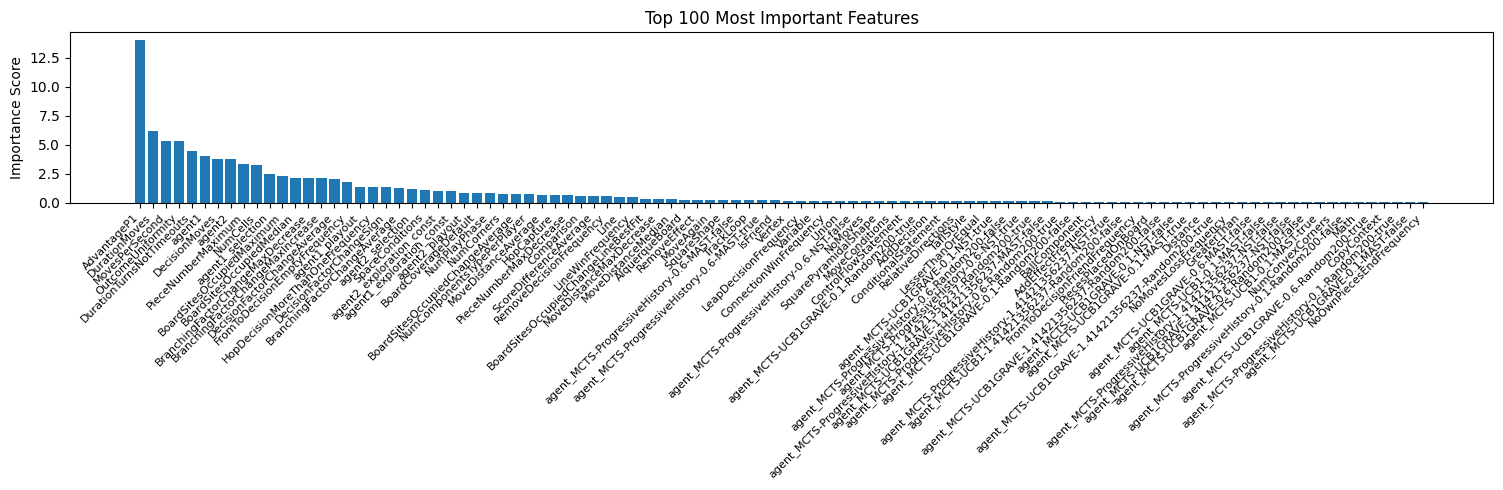

Fold 3 - RMSE: 0.408404856783478
Fold 4


0:	learn: 0.6110317	test: 0.5670630	best: 0.5670630 (0)	total: 71.8ms	remaining: 3m 35s


50:	learn: 0.3948890	test: 0.4610729	best: 0.4610729 (50)	total: 3.77s	remaining: 3m 38s


100:	learn: 0.3532644	test: 0.4468821	best: 0.4468821 (100)	total: 7.75s	remaining: 3m 42s


150:	learn: 0.3292425	test: 0.4396447	best: 0.4396447 (150)	total: 12s	remaining: 3m 45s


200:	learn: 0.3128333	test: 0.4362186	best: 0.4362186 (200)	total: 16.1s	remaining: 3m 43s


250:	learn: 0.3012048	test: 0.4339954	best: 0.4339954 (250)	total: 20.1s	remaining: 3m 40s


300:	learn: 0.2918904	test: 0.4325243	best: 0.4324202 (299)	total: 24.2s	remaining: 3m 36s


350:	learn: 0.2841293	test: 0.4314906	best: 0.4314906 (350)	total: 28.2s	remaining: 3m 33s


400:	learn: 0.2774273	test: 0.4310755	best: 0.4310339 (375)	total: 32.3s	remaining: 3m 29s


450:	learn: 0.2708458	test: 0.4305049	best: 0.4304724 (447)	total: 36.4s	remaining: 3m 25s


500:	learn: 0.2656087	test: 0.4302482	best: 0.4302482 (500)	total: 40.5s	remaining: 3m 21s


550:	learn: 0.2608912	test: 0.4294996	best: 0.4294996 (550)	total: 44.7s	remaining: 3m 18s


600:	learn: 0.2567932	test: 0.4290282	best: 0.4289789 (595)	total: 48.8s	remaining: 3m 14s


650:	learn: 0.2526235	test: 0.4286572	best: 0.4286532 (649)	total: 52.9s	remaining: 3m 10s


700:	learn: 0.2485853	test: 0.4282817	best: 0.4281741 (692)	total: 57s	remaining: 3m 7s


750:	learn: 0.2450990	test: 0.4280192	best: 0.4278681 (719)	total: 1m 1s	remaining: 3m 3s


800:	learn: 0.2420038	test: 0.4278137	best: 0.4277459 (776)	total: 1m 5s	remaining: 2m 59s


850:	learn: 0.2390832	test: 0.4273927	best: 0.4273927 (850)	total: 1m 9s	remaining: 2m 55s


900:	learn: 0.2362320	test: 0.4273903	best: 0.4273708 (865)	total: 1m 13s	remaining: 2m 51s


950:	learn: 0.2336039	test: 0.4274284	best: 0.4272652 (911)	total: 1m 17s	remaining: 2m 47s


1000:	learn: 0.2312470	test: 0.4273638	best: 0.4272652 (911)	total: 1m 22s	remaining: 2m 43s


1050:	learn: 0.2288218	test: 0.4272964	best: 0.4272539 (1029)	total: 1m 26s	remaining: 2m 40s


1100:	learn: 0.2262986	test: 0.4269751	best: 0.4269751 (1100)	total: 1m 30s	remaining: 2m 36s


1150:	learn: 0.2239890	test: 0.4268872	best: 0.4268506 (1139)	total: 1m 34s	remaining: 2m 32s


1200:	learn: 0.2220177	test: 0.4268048	best: 0.4267945 (1199)	total: 1m 39s	remaining: 2m 28s


1250:	learn: 0.2200472	test: 0.4266697	best: 0.4266531 (1232)	total: 1m 43s	remaining: 2m 24s


1300:	learn: 0.2180036	test: 0.4266016	best: 0.4265955 (1297)	total: 1m 47s	remaining: 2m 20s


1350:	learn: 0.2159135	test: 0.4265475	best: 0.4265157 (1330)	total: 1m 51s	remaining: 2m 16s


1400:	learn: 0.2138929	test: 0.4263243	best: 0.4263114 (1396)	total: 1m 55s	remaining: 2m 12s


1450:	learn: 0.2118840	test: 0.4262514	best: 0.4262361 (1449)	total: 2m	remaining: 2m 8s


1500:	learn: 0.2101235	test: 0.4261688	best: 0.4261059 (1474)	total: 2m 4s	remaining: 2m 4s


1550:	learn: 0.2085668	test: 0.4262291	best: 0.4261059 (1474)	total: 2m 8s	remaining: 1m 59s


1600:	learn: 0.2066723	test: 0.4262472	best: 0.4261059 (1474)	total: 2m 12s	remaining: 1m 55s


1650:	learn: 0.2050433	test: 0.4261842	best: 0.4261059 (1474)	total: 2m 16s	remaining: 1m 51s


1700:	learn: 0.2034005	test: 0.4261281	best: 0.4261059 (1474)	total: 2m 20s	remaining: 1m 47s


1750:	learn: 0.2017749	test: 0.4261567	best: 0.4260715 (1738)	total: 2m 24s	remaining: 1m 43s


1800:	learn: 0.2002874	test: 0.4261173	best: 0.4260679 (1796)	total: 2m 28s	remaining: 1m 39s


1850:	learn: 0.1986757	test: 0.4259388	best: 0.4259388 (1850)	total: 2m 33s	remaining: 1m 35s


1900:	learn: 0.1970524	test: 0.4259205	best: 0.4258789 (1869)	total: 2m 37s	remaining: 1m 30s


1950:	learn: 0.1956021	test: 0.4258986	best: 0.4258789 (1869)	total: 2m 41s	remaining: 1m 26s


2000:	learn: 0.1942249	test: 0.4259376	best: 0.4258789 (1869)	total: 2m 45s	remaining: 1m 22s


2050:	learn: 0.1928039	test: 0.4259587	best: 0.4258789 (1869)	total: 2m 49s	remaining: 1m 18s


2100:	learn: 0.1914384	test: 0.4258759	best: 0.4258759 (2100)	total: 2m 54s	remaining: 1m 14s


2150:	learn: 0.1900335	test: 0.4259061	best: 0.4258744 (2101)	total: 2m 59s	remaining: 1m 10s


2200:	learn: 0.1887216	test: 0.4259033	best: 0.4258744 (2101)	total: 3m 3s	remaining: 1m 6s


2250:	learn: 0.1873084	test: 0.4258604	best: 0.4258219 (2222)	total: 3m 7s	remaining: 1m 2s


2300:	learn: 0.1861072	test: 0.4258486	best: 0.4258213 (2273)	total: 3m 12s	remaining: 58.3s


2350:	learn: 0.1848108	test: 0.4258794	best: 0.4258213 (2273)	total: 3m 16s	remaining: 54.3s


2400:	learn: 0.1834640	test: 0.4259606	best: 0.4258213 (2273)	total: 3m 21s	remaining: 50.2s


2450:	learn: 0.1822590	test: 0.4259599	best: 0.4258213 (2273)	total: 3m 25s	remaining: 46.1s


2500:	learn: 0.1811256	test: 0.4260182	best: 0.4258213 (2273)	total: 3m 30s	remaining: 41.9s


2550:	learn: 0.1799258	test: 0.4259718	best: 0.4258213 (2273)	total: 3m 34s	remaining: 37.7s


2600:	learn: 0.1786995	test: 0.4259310	best: 0.4258213 (2273)	total: 3m 38s	remaining: 33.5s


2650:	learn: 0.1774140	test: 0.4259409	best: 0.4258213 (2273)	total: 3m 42s	remaining: 29.3s


2700:	learn: 0.1762354	test: 0.4259346	best: 0.4258213 (2273)	total: 3m 47s	remaining: 25.1s


2750:	learn: 0.1750456	test: 0.4259069	best: 0.4258213 (2273)	total: 3m 51s	remaining: 20.9s


2800:	learn: 0.1738362	test: 0.4259046	best: 0.4258213 (2273)	total: 3m 56s	remaining: 16.8s


2850:	learn: 0.1727986	test: 0.4258799	best: 0.4258213 (2273)	total: 4m	remaining: 12.6s


2900:	learn: 0.1715986	test: 0.4258573	best: 0.4258213 (2273)	total: 4m 4s	remaining: 8.35s


2950:	learn: 0.1705539	test: 0.4258725	best: 0.4258213 (2273)	total: 4m 8s	remaining: 4.13s


2999:	learn: 0.1696194	test: 0.4258994	best: 0.4258213 (2273)	total: 4m 13s	remaining: 0us

bestTest = 0.4258213131
bestIteration = 2273

Shrink model to first 2274 iterations.


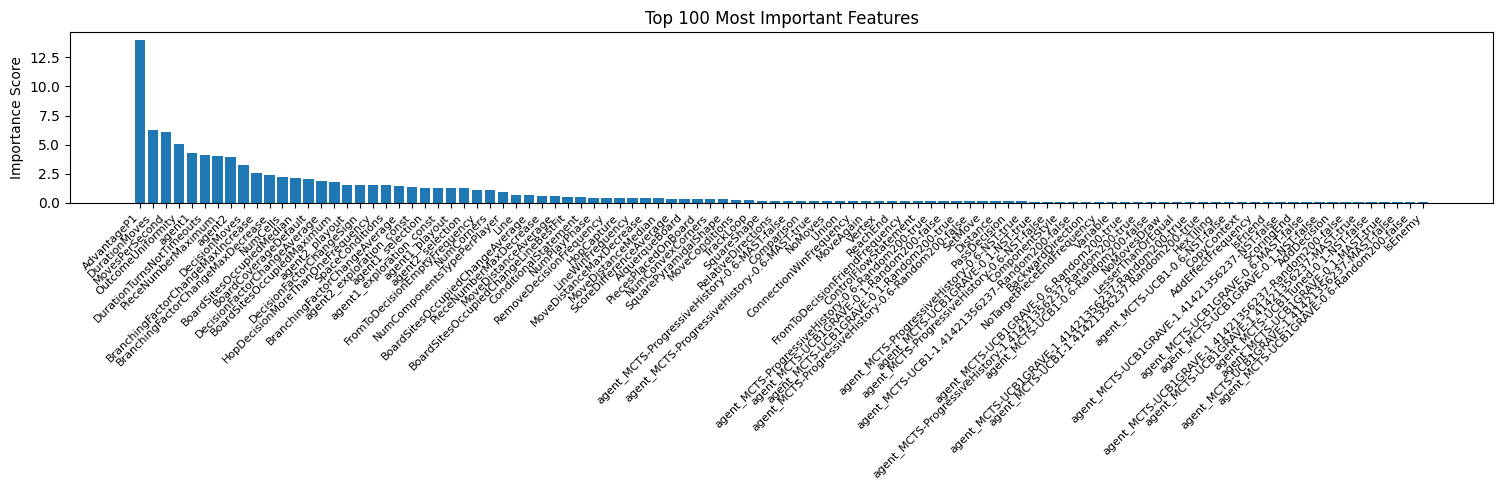

Fold 4 - RMSE: 0.4251913739779227
Fold 5


0:	learn: 0.6055693	test: 0.5789186	best: 0.5789186 (0)	total: 68.4ms	remaining: 3m 25s


50:	learn: 0.3955985	test: 0.4738630	best: 0.4738630 (50)	total: 4.05s	remaining: 3m 54s


100:	learn: 0.3531653	test: 0.4504481	best: 0.4504481 (100)	total: 8.25s	remaining: 3m 56s


150:	learn: 0.3307364	test: 0.4423535	best: 0.4423457 (149)	total: 12.5s	remaining: 3m 56s


200:	learn: 0.3150933	test: 0.4370235	best: 0.4370235 (200)	total: 16.8s	remaining: 3m 53s


250:	learn: 0.3031584	test: 0.4335495	best: 0.4335495 (250)	total: 21s	remaining: 3m 50s


300:	learn: 0.2940658	test: 0.4318051	best: 0.4318051 (300)	total: 25.3s	remaining: 3m 47s


350:	learn: 0.2864943	test: 0.4298056	best: 0.4298056 (350)	total: 29.7s	remaining: 3m 44s


400:	learn: 0.2796814	test: 0.4285663	best: 0.4285663 (400)	total: 34.1s	remaining: 3m 41s


450:	learn: 0.2743767	test: 0.4274729	best: 0.4274729 (450)	total: 38.9s	remaining: 3m 39s


500:	learn: 0.2688264	test: 0.4272666	best: 0.4272267 (463)	total: 43.5s	remaining: 3m 37s


550:	learn: 0.2641078	test: 0.4265613	best: 0.4265500 (548)	total: 48.1s	remaining: 3m 33s


600:	learn: 0.2589367	test: 0.4258570	best: 0.4258570 (600)	total: 52.6s	remaining: 3m 29s


650:	learn: 0.2547114	test: 0.4251688	best: 0.4251688 (650)	total: 57s	remaining: 3m 25s


700:	learn: 0.2506998	test: 0.4250035	best: 0.4249835 (698)	total: 1m 1s	remaining: 3m 21s


750:	learn: 0.2471204	test: 0.4247483	best: 0.4246997 (747)	total: 1m 6s	remaining: 3m 18s


800:	learn: 0.2436223	test: 0.4245837	best: 0.4245257 (770)	total: 1m 10s	remaining: 3m 13s


850:	learn: 0.2406765	test: 0.4244392	best: 0.4244179 (819)	total: 1m 15s	remaining: 3m 10s


900:	learn: 0.2372765	test: 0.4241637	best: 0.4241223 (894)	total: 1m 19s	remaining: 3m 5s


950:	learn: 0.2344811	test: 0.4239514	best: 0.4239514 (950)	total: 1m 24s	remaining: 3m 1s


1000:	learn: 0.2319120	test: 0.4238084	best: 0.4237748 (988)	total: 1m 29s	remaining: 2m 57s


1050:	learn: 0.2295481	test: 0.4238055	best: 0.4237354 (1013)	total: 1m 33s	remaining: 2m 53s


1100:	learn: 0.2270324	test: 0.4238504	best: 0.4237354 (1013)	total: 1m 38s	remaining: 2m 49s


1150:	learn: 0.2246345	test: 0.4236708	best: 0.4236169 (1144)	total: 1m 42s	remaining: 2m 44s


1200:	learn: 0.2223590	test: 0.4235935	best: 0.4235935 (1200)	total: 1m 47s	remaining: 2m 40s


1250:	learn: 0.2202276	test: 0.4234966	best: 0.4234896 (1246)	total: 1m 51s	remaining: 2m 35s


1300:	learn: 0.2182244	test: 0.4235057	best: 0.4234896 (1246)	total: 1m 56s	remaining: 2m 31s


1350:	learn: 0.2162814	test: 0.4232821	best: 0.4232821 (1350)	total: 2m	remaining: 2m 27s


1400:	learn: 0.2143665	test: 0.4232409	best: 0.4232409 (1400)	total: 2m 5s	remaining: 2m 22s


1450:	learn: 0.2125505	test: 0.4232913	best: 0.4231678 (1430)	total: 2m 9s	remaining: 2m 18s


1500:	learn: 0.2107645	test: 0.4231675	best: 0.4231275 (1497)	total: 2m 14s	remaining: 2m 14s


1550:	learn: 0.2090976	test: 0.4231276	best: 0.4231192 (1519)	total: 2m 18s	remaining: 2m 9s


1600:	learn: 0.2074056	test: 0.4230544	best: 0.4230255 (1571)	total: 2m 23s	remaining: 2m 5s


1650:	learn: 0.2056020	test: 0.4230532	best: 0.4229698 (1636)	total: 2m 28s	remaining: 2m 1s


1700:	learn: 0.2038021	test: 0.4229091	best: 0.4228819 (1697)	total: 2m 32s	remaining: 1m 56s


1750:	learn: 0.2022789	test: 0.4228252	best: 0.4228238 (1749)	total: 2m 37s	remaining: 1m 52s


1800:	learn: 0.2006656	test: 0.4227919	best: 0.4227709 (1775)	total: 2m 42s	remaining: 1m 47s


1850:	learn: 0.1991493	test: 0.4227931	best: 0.4227632 (1836)	total: 2m 46s	remaining: 1m 43s


1900:	learn: 0.1976034	test: 0.4227685	best: 0.4227531 (1881)	total: 2m 51s	remaining: 1m 39s


1950:	learn: 0.1962169	test: 0.4227546	best: 0.4227431 (1909)	total: 2m 55s	remaining: 1m 34s


2000:	learn: 0.1947421	test: 0.4226880	best: 0.4226880 (2000)	total: 3m	remaining: 1m 30s


2050:	learn: 0.1932097	test: 0.4225994	best: 0.4225875 (2048)	total: 3m 5s	remaining: 1m 25s


2100:	learn: 0.1917207	test: 0.4225045	best: 0.4224727 (2096)	total: 3m 9s	remaining: 1m 21s


2150:	learn: 0.1903203	test: 0.4224550	best: 0.4224494 (2144)	total: 3m 14s	remaining: 1m 16s


2200:	learn: 0.1889117	test: 0.4224538	best: 0.4224426 (2189)	total: 3m 19s	remaining: 1m 12s


2250:	learn: 0.1875822	test: 0.4223935	best: 0.4223890 (2246)	total: 3m 23s	remaining: 1m 7s


2300:	learn: 0.1863272	test: 0.4223763	best: 0.4223693 (2272)	total: 3m 28s	remaining: 1m 3s


2350:	learn: 0.1849939	test: 0.4223622	best: 0.4223565 (2347)	total: 3m 32s	remaining: 58.8s


2400:	learn: 0.1837768	test: 0.4223915	best: 0.4223497 (2388)	total: 3m 37s	remaining: 54.2s


2450:	learn: 0.1825350	test: 0.4223285	best: 0.4223252 (2449)	total: 3m 41s	remaining: 49.7s


2500:	learn: 0.1813678	test: 0.4223493	best: 0.4222941 (2468)	total: 3m 46s	remaining: 45.2s


2550:	learn: 0.1801037	test: 0.4223152	best: 0.4222941 (2468)	total: 3m 51s	remaining: 40.7s


2600:	learn: 0.1788531	test: 0.4222402	best: 0.4222306 (2597)	total: 3m 55s	remaining: 36.1s


2650:	learn: 0.1776347	test: 0.4221967	best: 0.4221922 (2641)	total: 3m 59s	remaining: 31.6s


2700:	learn: 0.1765267	test: 0.4222187	best: 0.4221771 (2656)	total: 4m 4s	remaining: 27.1s


2750:	learn: 0.1754333	test: 0.4221905	best: 0.4221771 (2656)	total: 4m 9s	remaining: 22.5s


2800:	learn: 0.1742970	test: 0.4221431	best: 0.4221329 (2796)	total: 4m 13s	remaining: 18s


2850:	learn: 0.1731944	test: 0.4222385	best: 0.4221329 (2796)	total: 4m 18s	remaining: 13.5s


2900:	learn: 0.1721399	test: 0.4222533	best: 0.4221329 (2796)	total: 4m 22s	remaining: 8.96s


2950:	learn: 0.1710779	test: 0.4223050	best: 0.4221329 (2796)	total: 4m 27s	remaining: 4.43s


2999:	learn: 0.1700024	test: 0.4222603	best: 0.4221329 (2796)	total: 4m 31s	remaining: 0us

bestTest = 0.4221328852
bestIteration = 2796

Shrink model to first 2797 iterations.


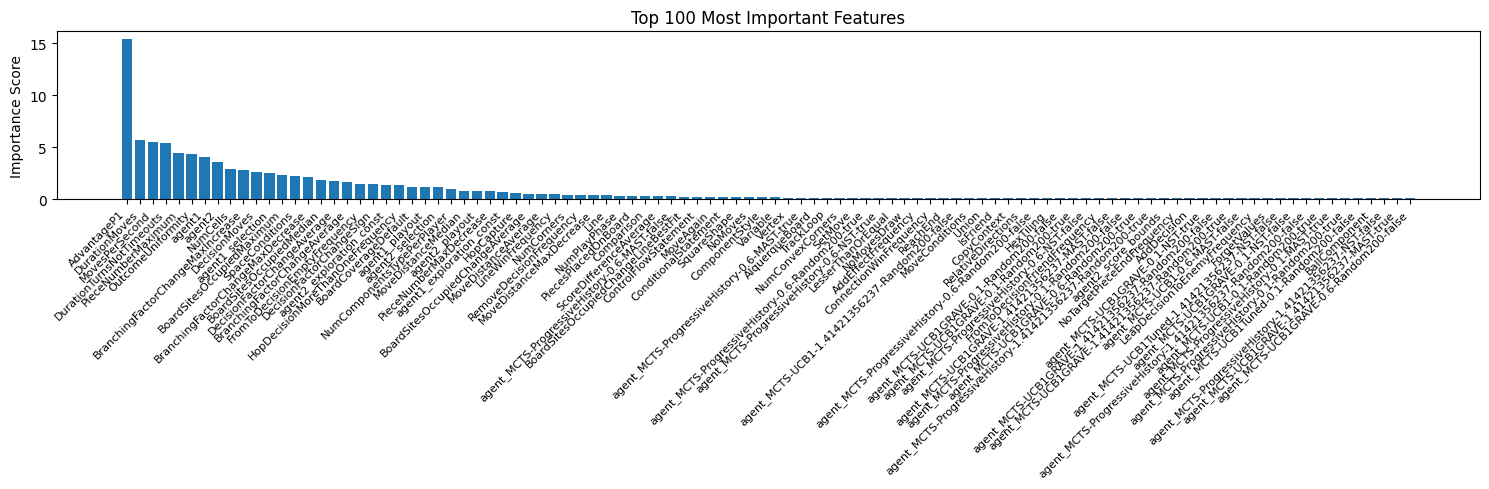

Fold 5 - RMSE: 0.4215605093313796
List of oof scores: [0.42792657835597286, 0.41555135839155255, 0.408404856783478, 0.4251913739779227, 0.4215605093313796]
Average oof score: 0.41972693536806116


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train, 
    numerical_cols, 
    categorical_cols, 
    text_cols=text_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_catboost_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")


CV1 OOF Scores:
Score: 0.4269
Score: 0.4311
Score: 0.4264
Score: 0.4333
Score: 0.4045
Average CV1 Score: 0.4245

CV2 OOF Scores:
Score: 0.4153
Score: 0.4041
Score: 0.4246
Score: 0.4343
Score: 0.4265
Average CV2 Score: 0.4210

CV3 OOF Scores:
Score: 0.4279
Score: 0.4156
Score: 0.4084
Score: 0.4252
Score: 0.4216
Average CV3 Score: 0.4197


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

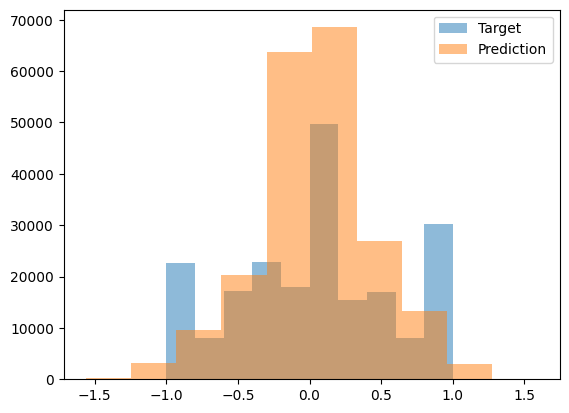

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame):
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler,
        include_position_features=True,
        include_text_features=True,
    )

    # Create CatBoost Pool for test data
    test_pool = cb.Pool(
        # data=test_processed[numerical_cols + categorical_cols + text_cols],
        data=test_processed[numerical_cols + categorical_cols],
        cat_features=categorical_cols,
        # text_features=text_cols,
    )

    # Average predictions from all models
    predictions = np.mean([
        model.predict(test_pool)
        for model in trained_models
    ], axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.125761       │
│ 233235 ┆ -0.118601      │
│ 233236 ┆ -0.041169      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
catboost_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'text_cols': text_cols,
    'encoder': encoder, 
    'scaler': scaler
}
with open(f'./catboost_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(catboost_predict, f)

***